In [39]:
import os
import time
from collections import Counter, OrderedDict
from itertools import islice
import smart_open

import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import xml.etree.ElementTree as ET  

import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster, ensemble, linear_model, naive_bayes, neighbors, svm
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit


from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings(
    module='gensim',
    action='ignore',
    message='Conversion')
warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')
warnings.filterwarnings("ignore",category=DeprecationWarning)


default_stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.snowball.SnowballStemmer('english')
sns.set(style='darkgrid',context='poster',palette='inferno')
%matplotlib inline


 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [ ]:
glob_time1 = time.time()

### Importing the data
    - The texts consist of the closed captioning for 93 lectures on varying topics in mathematics, computer science, and engineering
    - The XML files were accessed through the console in a web browser and saved as XML 

In [40]:
#set path to XML files
path = '/root/Desktop/gits/ds-unit4/lectures'
folder = os.fsencode(path)

#get list of the filenames
filenames = sorted([re.sub('.xml','',os.fsdecode(file)) for file in os.listdir(folder)])
#filenames = [ re.sub('.xml','',i) for i in filenames ]

#Use ElementTree trace xml tree and extract text from xml files, removing tags
lecture_texts = []
for file in filenames:
    tree = ET.parse('lectures/{}.xml'.format(file))
    root = tree.getroot()
    all_text = []
    for elem in root:  
        for subelem in elem:
            all_text.append(subelem.text)
    lecture_texts.append(all_text)

In [41]:
#check some text from a random lecture
lecture_texts[47][30:35]

['the most common change of\nvariables is the one simple one',
 'called scaling.\nSo, again, the kind of equation',
 "I'm talking about is a general\nfirst-order equation.",
 'And, scaling simply means to\nchange the coordinates,',
 'in effect, or axes,\nto change the coordinates on']

In [42]:
#create a DataFrame for records
raw_data = pd.DataFrame()
raw_data['filename'] = filenames
raw_data['raw_text'] = [ ' '.join(i) for i in lecture_texts ] #unpack list of lists as string
print(type(raw_data.raw_text[0]))
raw_data.head(1)

<class 'str'>


filename                                           raw_text
0  aurouxmcalc1  So let's start right away with\nstuff that we ...

### Cleaning the text

Now we will clean the text removing '\n', the intros (MIT has a long intro), the professor names and other undesirable punctuation etc. Also, we want to replace contractions with thier full counterparts.

In [43]:
#Function to remove identified words through visual inspection
def text_cleaner(text):
    text = re.sub(r'--',', ',text) # unrecognized punctuation
    text = re.sub("[\[].*?[\]]", "", text) #remove in [audible],[laughter] etc
    text = ' '.join(text.split()) #for one long string
    #remove intros,professor names
    text = re.sub("The following content is provided under a Creative Commons license. ",'',text)
    text = re.sub('Your support will help MIT OpenCourseWare continue to',' ',text)
    text = re.sub(' offer high quality educational resources for free.',' ',text)
    text = re.sub('To make a donation or ',' ',text)
    text = re.sub('view additional materials from hundreds of MIT',' ',text)   
    text = re.sub(' courses, visit MIT OpenCourseWare at ocw.mit.edu.',' ',text)   
    text = re.sub('Haynes Miller','PROFESSOR',text)
    text = re.sub('David Jerison','PROFESSOR',text)
    text = re.sub('Srini Devadas','PROFESSOR',text)
    text = re.sub('Gilbert Strang','PROFESSOR',text)
    text = re.sub('TOM LEIGHTON','PROFESSOR',text)
    text = re.sub('PHILIPPE RIGOLLET','PROFESSOR',text)
    text = re.sub('PROFESSOR STRANG','PROFESSOR',text)
    text = re.sub('PROF. PATRICK WINSTON','PROFESSOR',text)
    text = re.sub('PROFESSOR PATRICK WINSTON','PROFESSOR',text)   
    text = re.sub('ERIK DEMAINE','PROFESSOR',text)
    text = re.sub('Demaine','PROFESSOR',text)
    text = re.sub('Erik','PROFESSOR',text)
    text = re.sub('PROF. JERISON','PROFESSOR',text)
    text = re.sub('ERIK DOMANE','PROFESSOR',text)
    text = re.sub('Erik Domane','PROFESSOR',text)
    text = re.sub('Stanford University. >>', '',text)
    text = re.sub('PATRICK WINSTON', 'PROFESSOR',text)
    text = re.sub('Welcome to 6.851 Advanced Data Structures', 'PROFESSOR',text)
    text = re.sub('PROFESSOR: PROFESSOR', ' ',text)
    text = re.sub('PROFESSOR PROFESSOR', ' ',text)
    return text

#list common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)


In [44]:
raw_data.raw_text = [ expand_contractions(i) for i in raw_data.raw_text]
raw_data.raw_text = [ text_cleaner(i) for i in raw_data.raw_text]

In [45]:
#label professors
raw_data['Professor'] = ['Auroux']*4 + ['Demaine']*7 + ['Devadas']*9 + ['Jerison']*9 + ['Leighton']*11 + ['Manning']*3 + ['Mattuck']*9\
+ ['Rigollet']*10 + ['Socher']*4 + ['Strang']*18 + ['Winston']* 8
#label_subjects
raw_data['Subject'] = ['Calculus']*4 + ['Data']*7 + ['Algorithms']*9 + ['Calculus']*9 + ['CS Math']*11 + ['NLP']*3\
+ ['Differential Equations']*9+ ['Statistics']*10 + ['NLP']*4 + ['Linear Algebra']*10 + ['Mech. Eng']* 8 +\
['AI']*8
raw_data.head(1)

filename                                           raw_text Professor  \
0  aurouxmcalc1  So let us start right away with stuff that we ...    Auroux   

    Subject  
0  Calculus

### Tokenization with spacy

Here we will parse the text using spacy and append each spacy object (each lecture) to the dataframe.
Then we make a new data frame with the professor, subject, filename and the spacy doc.
We will use a list comprehension to tokenize each sentences from each lecture and append the list of lists to the dataframe.
Then we will drop the spacy doc, we will -explode- the data frame so that each sentence is an observation, while maintaining tracability to the lecture level.
We will also take the sentence length for further sentence elimination.

In [46]:
#Create Spacy document for each lecture
t1 = time.time()
nlp = spacy.load('en')
raw_data['sdoc'] = [nlp(i) for i in raw_data.raw_text]
print('Minutes: {}'.format((time.time()-t1)/60))

Minutes: 4.260573355356852


In [47]:
#create a new data frame for the professor,subject and the spacy doc
sentences = raw_data[['filename','Professor','Subject','sdoc']].copy()

#create a list of lists of tokens (remove stop words and punct) 
sentences['sents'] = [ [ [token.lemma_.lower() for token in sent if not token.is_stop
        and not token.is_punct] for sent in doc.sents] for doc in sentences.sdoc]

#explode the df to a new df with each sentence on one line
sentences1 = pd.DataFrame({
         col:np.repeat(sentences[col].values, sentences['sents'].str.len())
         for col in sentences.columns.difference(['sents'])
         }).assign(**{'sents':np.concatenate(sentences['sents'].values)})[sentences.columns.tolist()]

#get sentence lengths
sentences1['s_len'] = [len(sent) for sent in sentences1.sents]

In [48]:
#check to make sure distribution of attributes to sentences
sentences1.sample(5,random_state=43)

filename Professor     Subject  \
59242         strangmeng5    Strang   Mech. Eng   
11965       devadasalgos3   Devadas  Algorithms   
5335        demainedata15   Demaine        Data   
57511         strangmeng2    Strang   Mech. Eng   
23516  leighton15linearcs  Leighton     CS Math   

                                                    sdoc  \
59242  (   , To, make, a, donation, ,, or, to,    , P...   
11965  (       , PROFESSOR, :, So, today, 's, lecture...   
5335   (       , PROFESSOR, :, All, right, ., Today, ...   
57511  (Your, support, will, help, MIT, OpenCourseWar...   
23516  (  , offer, high, -, quality, educational, res...   

                                                   sents  s_len  
59242                      [-pron-, be, get, zero, will]      5  
11965  [the, reason, interested, algorithm, people, w...      7  
5335                     [but, general, small, power, 2]      5  
57511                   [so, be, differential, equation]      4  
23516                                        [professor]      1

In [49]:
sentences1.shape

(65569, 6)

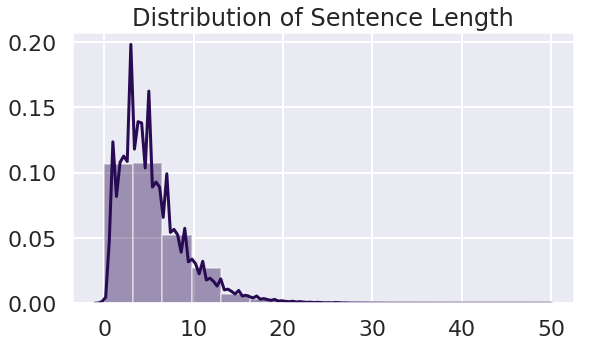

count    65569.000000
mean         5.470649
std          3.800854
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         49.000000
Name: s_len, dtype: float64

In [50]:
plt.figure(figsize=(9,5))
sns.distplot(tuple(sentences1.s_len),bins=15)
plt.title('Distribution of Sentence Length')
plt.show()

sentences1.s_len.describe()

In [51]:
sentences1.shape

(65569, 6)

Currently we have 65000+ sentences that need to be vectorized and processed. In order to avoid complications with the vectorization and clustering, I will set a minimum word length for each sentence.
    
    - Create a list of index numbers to keep
    - Replace the dataframe with only desired index numbers
    - Convert lists of tokens to strings
    - Remove '-pron-' token created by spacy
We've set a window of 9 to 16 sentence size. This will reduce the number of sentences to around 10,000, while hopefully still preserving the substance of the texts.  This is really a compromise. Vectorizing and processing 66,000 sentences is computationally and time intensive, so we want the reduction. Plus, I don't want the model to think sentences like "That's Right" or "Now, what?" or any other short meaningless statement you would hear in a math lecture are more important than longer sentences describing a concept.

In [52]:
#list index numbers to keep
to_keep = [ i for i in sentences1.index if len(sentences1.sents[i]) >= 9 and len(sentences1.sents[i]) <= 16]
#keep index numbers,execute other steps
sentences1 = sentences1.iloc[to_keep]
sentences1['text'] = [' '.join(i) for i in list(sentences1.sents)]
sentences1.text = [ re.sub("-pron-","",sentences1.text[i]) for i in to_keep]
sentences1.reset_index(inplace=True, drop=True) #reset the index here
sentences1.sample(5, random_state=43)

filename Professor     Subject  \
3177  leighton14dandcs  Leighton     CS Math   
6641   rigolletstats19  Rigollet  Statistics   
9408       strangmeng6    Strang   Mech. Eng   
7650       sochernlp13    Socher         NLP   
2590     jerisoncalc21   Jerison    Calculus   

                                                   sdoc  \
3177  (       , PROFESSOR, :, This, week, we, are, g...   
6641  (    , to,    , PROFESSOR, :, ,, bunch, of, x,...   
9408  (   , To, make, a, donation, ,, or, to,    , P...   
7650  ( , Network, ,, there, is, actually, a, whole,...   
2590  (   , To, make, a, donation, ,, or, to,    , P...   

                                                  sents  s_len  \
3177  [all, right, like, know, long, till, world, en...      9   
6641  [think, realization, guy, go, cloud, n, point,...      9   
9408  [so, -pron-, want, sum, square, -pron-, think,...      9   
7650  [well, model, go, see, small, norm, feature, v...     11   
2590  [and, -pron-, think, order, answer, question, ...     12   

                                                   text  
3177        all right like know long till world end t64  
6641        think realization guy go cloud n point r d.  
9408     so  want sum square  think cos(theta sin(theta  
7650  well model go see small norm feature vector z ...  
2590  and  think order answer question  go detail me...

In [53]:
sentences1.shape

(10156, 7)

### Split the data 
 - We need to split the data for training and testing purposes, we will set X as the sentences and Y as the labels to maintain traceability

In [54]:
#Split the data into train and test set.
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

### Tf-Idf Vectorization of the sentences
    Right now we are going to create numerical vectors for each sentence using the Tf-idf feature from the genism library.

In [55]:
#Instantiate tf-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more 50% of the sentences
                             min_df=25, # only use words that appear at least 15
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',  
                             smooth_idf=True 
                            )

In [56]:
#Fit vectorizer and transform X_train to vectors
X_train_tfidf = vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_train_tfidf_csr = X_train_tfidf.tocsr() #Reshapes the vectorizer output into something people can read
n = X_train_tfidf_csr.shape[0] #number of sentences
tfidf_bysent = [{} for _ in range(0,n)] #A list of dictionaries, one per sentence
terms = vectorizer.get_feature_names() #List of features
#for each sent, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]
print('Original sentence:', X_train[4421],y_train[4421])
print('Tf_idf vector:', tfidf_bysent[4421])

Number of features: 453
Original sentence: after find eigenvalue lambda omega squared know omegas find eigenvector ['Strang' 'Mech. Eng' 'strangmeng10']
Tf_idf vector: {'know': 0.3611194426533281, 'omega': 0.5501703808312975, 'squared': 0.5194008067903516, 'lambda': 0.5450945808749401}


In [57]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
df_similarity = pd.DataFrame(cosine_similarity(X_train_tfidf), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns


In [58]:
df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

In [59]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [60]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
1672                                           0.709474                         
5563                                           0.702142                         
6827                                           0.686053                         
6662                                           0.649410                         

                                      Original_Sentence Professor  \
4421  after find eigenvalue lambda omega squared kno...    Strang   
1672  and denominator omega nought squared minus ome...   Mattuck   
5563  ay = lambda*y multiply a. a squared*y lambda*a...    Strang   
6827  omega square root omega nought squared minus p...   Mattuck   
6662     omega d omega square plus omega nought squared   Mattuck   

                     Subject       filenames  mean_similarity  
4421               Mech. Eng    strangmeng10         0.013513  
1672  Differential Equations  mattuckdifeq10         0.013710  
5563               Mech. Eng     strangmeng6         0.006807  
6827  Differential Equations  mattuckdifeq10         0.015854  
6662  Differential Equations  mattuckdifeq10         0.012165

Now that we have vectorized and calculated the similarity between sentences. We will cluster the sentences and see if we can draw a meaningful conclusions about how the data is clustered.

In [61]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(X_train_tfidf.todense())

pca_kclusters = pd.DataFrame()
pca_kclusters['original'] = X_train
pca_kclusters['Professor'] = y_train[:,0]
pca_kclusters['Subject'] = y_train[:,1]
pca_kclusters['PCA_1'] = Y[:,0]
pca_kclusters['PCA_2'] = Y[:,1]
pca_kclusters['filename'] = y_train[:,2]
df_similarity['PCA_1'] = Y[:,0]
df_similarity['PCA_2'] = Y[:,1]

Now that the dimension has been reduced to two, we can scatter the results and color the cluster label, for a given number of clusters.
I chose to test 5, 10, 11, 25, 93. 10,11,93 because it is the number of professors,subjects,lectures respectively.
For good measure I try 5 (lower than the desired cluster amount) and 25 (higher than the desired number).


The desired number of clusters is based on number of subjects and number of professors. >> 10 or 11

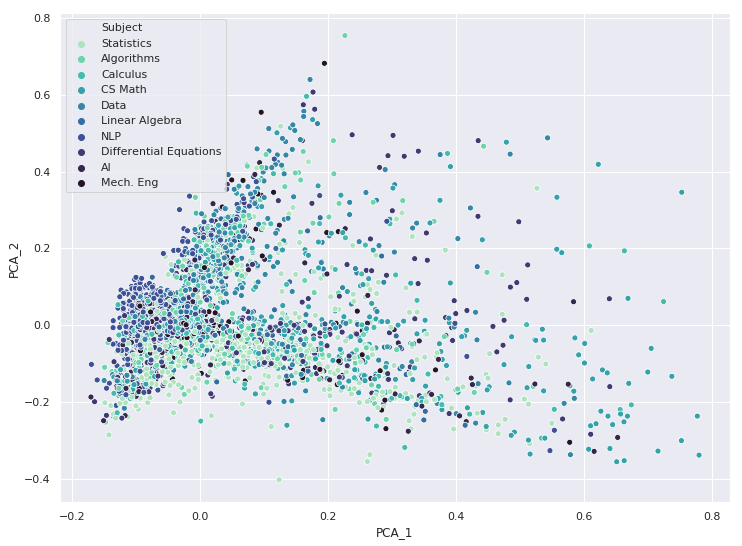

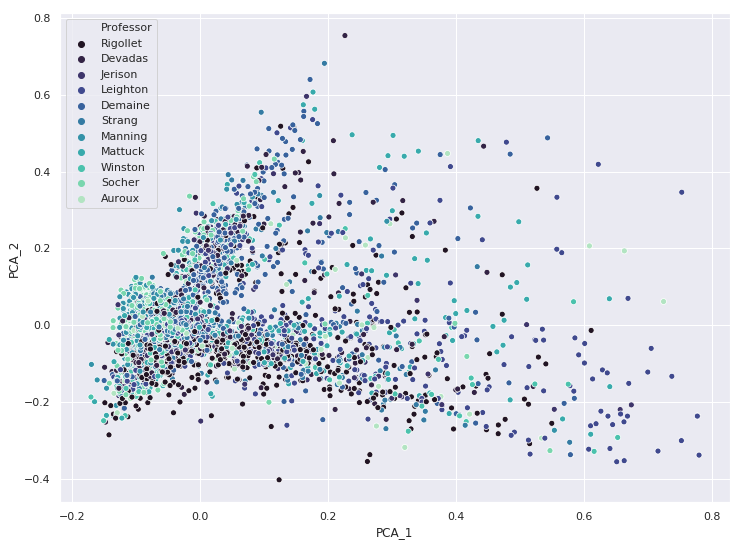

In [62]:
sns.set_context('notebook')
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Subject',data=pca_kclusters,palette='mako_r')
plt.show()
plt.figure(figsize=(12,9))
sns.scatterplot(x='PCA_1',y='PCA_2', hue='Professor',data=pca_kclusters,palette='mako')
plt.show()

Number of Clusters: 5

Silhouette avg 5 clusters: 0.16612681923233086




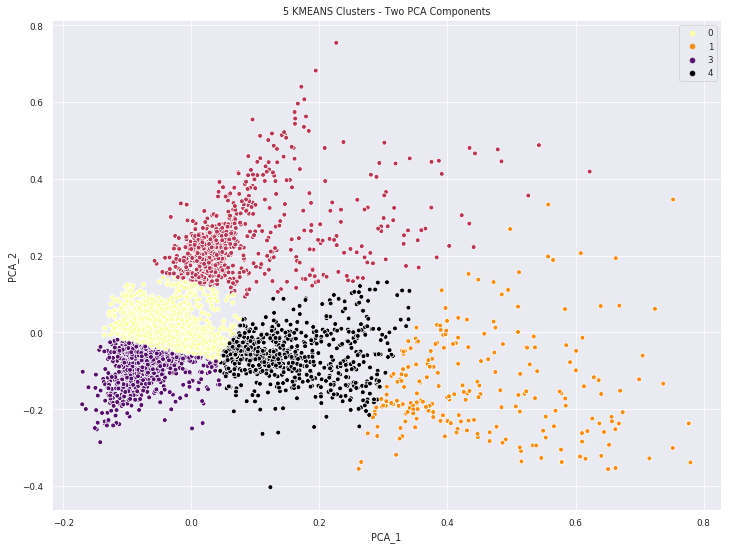

Number of observations per cluster:
0    4568
3    1391
2     712
4     691
1     255
dtype: int64
Time: 2.0502355098724365 seconds.

Number of Clusters: 6

Silhouette avg 6 clusters: 0.11977600549698074




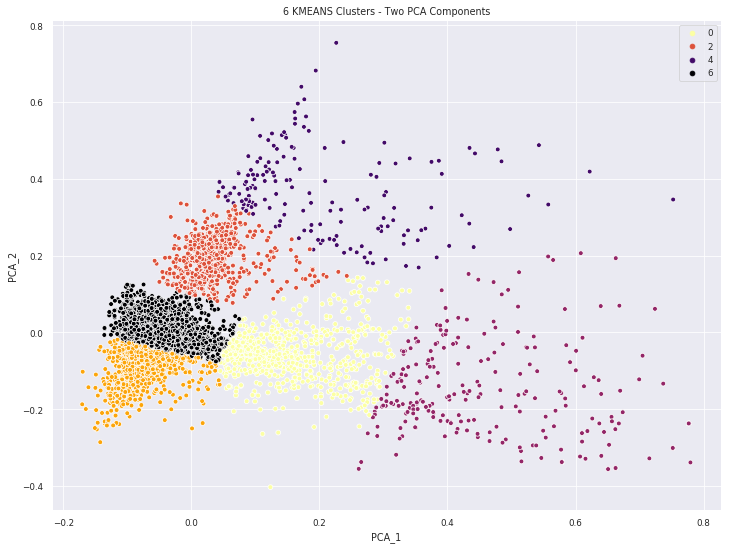

Number of observations per cluster:
5    4581
1    1307
0     693
2     612
3     252
4     172
dtype: int64
Time: 2.174961805343628 seconds.

Number of Clusters: 7

Silhouette avg 7 clusters: 0.1392754484385181




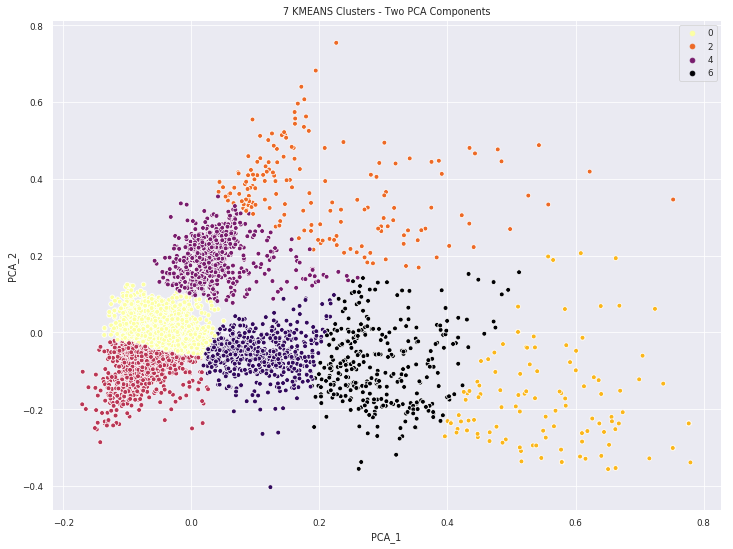

Number of observations per cluster:
0    4495
3    1291
4     614
5     597
6     316
2     172
1     132
dtype: int64
Time: 2.1440277099609375 seconds.

Number of Clusters: 8

Silhouette avg 8 clusters: 0.09547043142006462




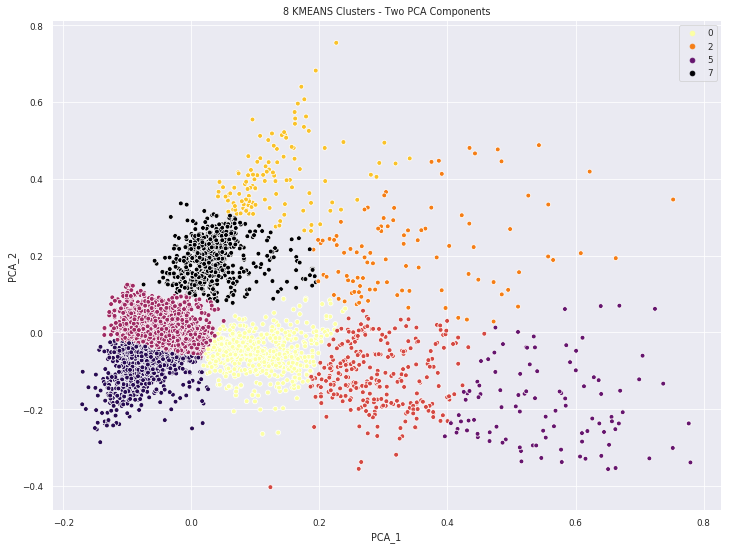

Number of observations per cluster:
4    4498
6    1286
7     600
0     599
3     282
5     127
1     123
2     102
dtype: int64
Time: 2.411775588989258 seconds.

Number of Clusters: 9

Silhouette avg 9 clusters: -0.009033969047075398




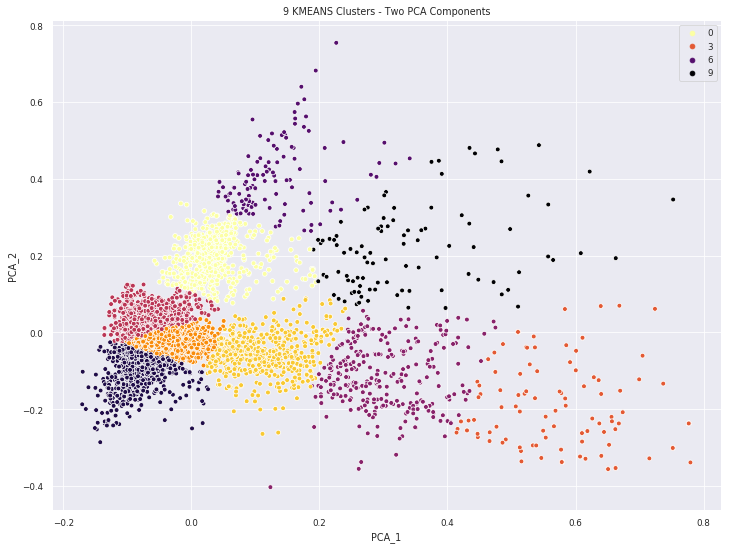

Number of observations per cluster:
2    3382
4    1481
7     961
0     590
1     580
5     285
6     123
3     116
8      99
dtype: int64
Time: 2.1108083724975586 seconds.

Number of Clusters: 10

Silhouette avg 10 clusters: -0.002451319009319855




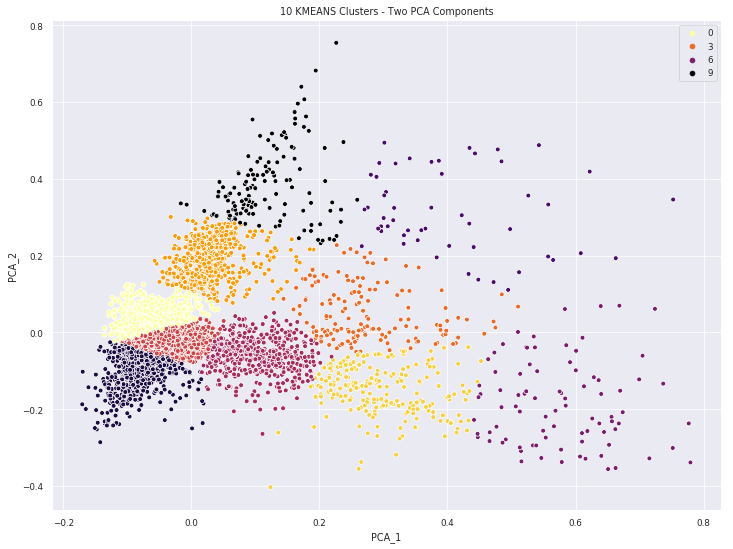

Number of observations per cluster:
4    3417
0    1438
8     949
2     563
5     561
1     224
3     161
9     142
6     109
7      53
dtype: int64
Time: 2.150057554244995 seconds.

Number of Clusters: 11

Silhouette avg 11 clusters: -0.10475802220049409




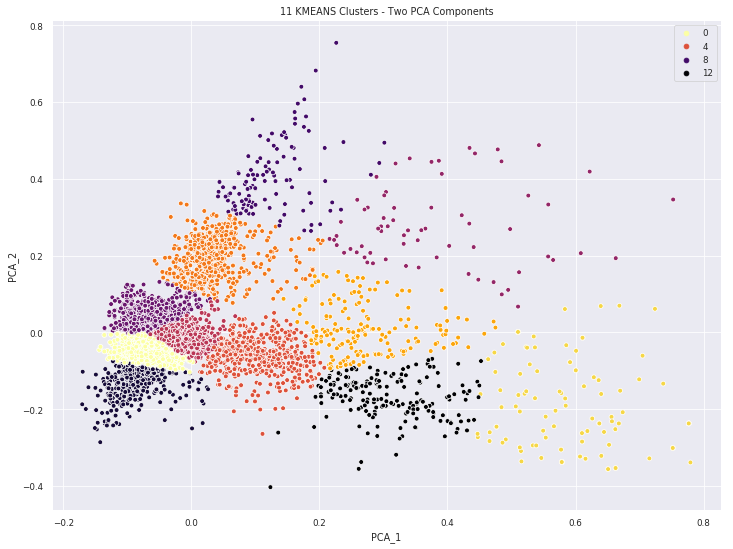

Number of observations per cluster:
5     2594
0     1679
7     1153
3      585
4      541
9      402
10     186
2      184
8      118
1      106
6       69
dtype: int64
Time: 2.1837260723114014 seconds.

Number of Clusters: 25

Silhouette avg 25 clusters: -0.2297576681222588




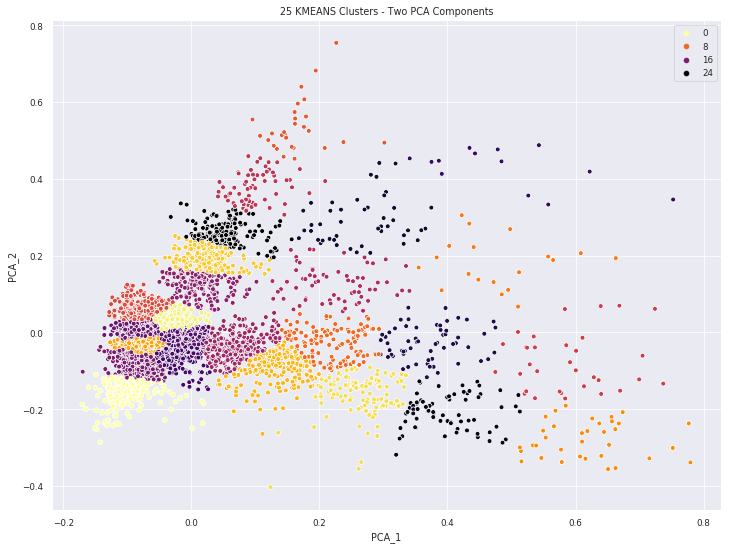

Number of observations per cluster:
18    1648
5      954
17     849
1      833
16     495
19     479
14     333
10     280
3      259
4      217
0      202
15     192
dtype: int64
Time: 2.9443347454071045 seconds.

Number of Clusters: 93

Silhouette avg 93 clusters: -0.4538994754156385




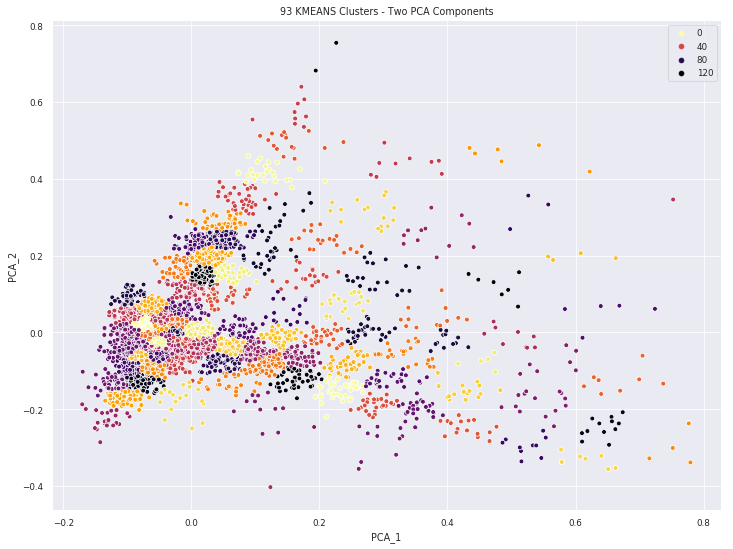

Number of observations per cluster:
80    625
58    491
20    465
3     348
30    339
40    290
53    258
0     256
29    245
65    241
52    229
15    195
dtype: int64
Time: 5.308509826660156 seconds.



In [63]:
sns.set_context('paper')
k_clusters = [5,6,7,8,9,10,11,25,93]
for i in k_clusters:
    t1 = time.time()
    modelk_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette avg {} clusters:'.format(i), silhouette_score(Y, modelk_clusters, metric='cosine'))
    print('\n')
    pca_kclusters['cluster_k='+str(i)] = modelk_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue=modelk_clusters, data=pca_kclusters,palette='inferno_r')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} KMEANS Clusters - Two PCA Components".format(i))   
    plt.show()    
    print('Number of observations per cluster:')
    print(pd.value_counts(modelk_clusters)[:12])
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

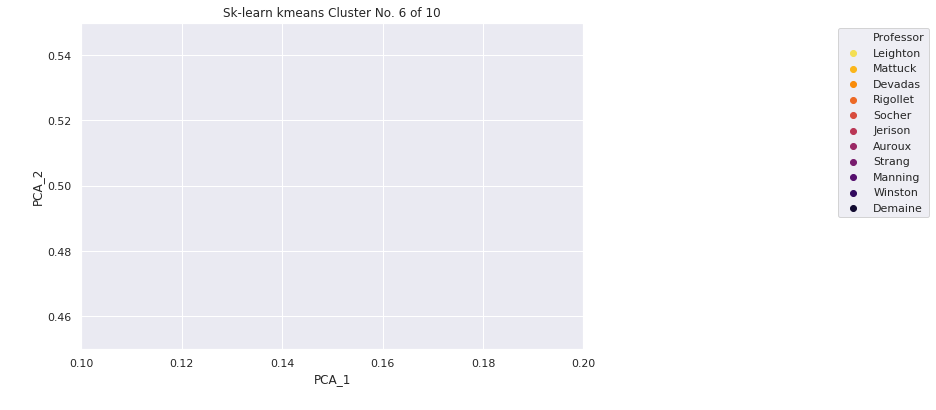

In [64]:
cluster6 = pca_kclusters[pca_kclusters['cluster_k=10'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_kclusters[pca_kclusters['cluster_k=10'] == 6],
                palette='inferno_r')
for label, x, y in zip(cluster6.original,cluster6.PCA_1,cluster6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

plt.xlim(.1,.2)
plt.ylim(.45,.55)
plt.title('Sk-learn kmeans Cluster No. 6 of 10')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()    


So far its hard to tell what the algorithm is doing. The silhouette scores are pretty horrible. They range from .5 to -.47. A large loss in score occurs between 5 and 6 clusters.

### Doc2Vec model from gensim
Learn paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”.

The algorithms use either hierarchical softmax or negative sampling; see Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean: “Efficient Estimation of Word Representations in Vector Space, in Proceedings of Workshop at ICLR, 2013” and Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean: “Distributed Representations of Words and Phrases and their Compositionality. In Proceedings of NIPS, 2013”.
https://radimrehurek.com/gensim/models/doc2vec.html

When training a Doc2Vec model, both word representations and paragraph representations are stored. Using the vector representation of each sentence in the model, we can then attempt to cluster the data again and compare the results with our tf-idf vectors. 

#### Important features of the Doc2Vec Class
    -Word2VecKeyedVectors – This object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways.
    
    - Doc2VecKeyedVectors – This object contains the paragraph vectors. Remember that the only difference between this model and Word2Vec is that besides the word vectors we also include paragraph embeddings to capture the paragraph.

    In this way we can capture the difference between the same word used in a different context. For example we now have a different representation of the word “leaves” in the following two sentences

    1. Manos leaves the office every day at 18:00 to catch his train
    2. This season is called Fall, because leaves fall from the trees.

    In a plain Word2Vec model the word would have exactly the same representation in both sentences, in Doc2Vec it will not.


In [65]:
#Split the data exactly the way it was previously split
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [66]:
#The Doc2Vec takes a tagged document as the input,with the tokenized sentences and an identification tag.

In [67]:
#tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [68]:
#Train the model

#max training epochs
max_epochs = 100

model = Doc2Vec(vector_size=100, # 100 dimensions should be fine for our corpus
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=7, #ignores all words with total frequency lower than this.
                dm =1) #algorith 1=distributed memory

#Build vocabulary from a sequence of sentences (can be a once-only generator stream).
model.build_vocab(tagged_data)

#train 100 epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
t2 = time.time()    
model.save("math_lects2.model")
print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [69]:
#load the saved model
model= Doc2Vec.load("math_lects2.model")

In [70]:
X_train.shape

(7617,)

In [71]:
#extract the vectors from the model 
vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])
print(tagged_data[4421])
print(model.docvecs['4421'])

TaggedDocument(['after', 'find', 'eigenvalue', 'lambda', 'omega', 'squared', 'know', 'omegas', 'find', 'eigenvector'], ['4421'])
[-0.7387157   0.54388034  1.8242437   0.48806015  0.8267898  -1.9521345
  0.37155896 -1.5514973  -0.19918455 -1.1296406   0.68008554  1.2208686
 -0.19884983  0.040087    1.387104    0.4031168   0.10703682 -1.2148846
  1.1440018   0.30144393  0.5789899   0.38950166  0.7911262   0.54989
  0.99149644  0.878841   -0.7483154   0.22678451  0.36143503  0.6627704
  1.2785248  -0.4328285  -0.07232647  1.1005605   0.8471751  -0.81304795
 -0.01647325  2.4486463   0.1205503   1.2119042  -0.1890828  -1.1341221
 -1.4276192  -0.72185004 -1.0568494  -1.1072291   0.82780015 -1.2348304
 -0.9769478   0.4559134  -0.33618188  2.1744373   2.305881   -0.6310655
 -0.6655404   0.26730606 -0.25391927  0.56790113 -0.627312   -0.25864658
 -2.3962607  -0.6137148   4.2106194   0.8908519   0.42747763 -0.4558714
  1.3750429  -0.997288   -0.06307471  0.74217665  0.29761475 -0.25766787
  0.15

In [72]:
vecs.shape

(7617, 100)

In [73]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
d2v_sim = pd.DataFrame(cosine_similarity(vecs), index=range(len(X_train)),
                            columns=X_train) # set sentneces for the rows and columns
#calculate the mean similarity of each sentence
d2v_sim.insert(0, 'mean_similarity', d2v_sim.mean(axis=1))

In [74]:
#add identification to similarity dataframe
d2v_sim['Professor'] = y_train[:,0]
d2v_sim['Subject'] = y_train[:,1]
d2v_sim['Original_Sentence'] = X_train
d2v_sim['filenames'] = y_train[:,2]

In [75]:
#check benchmark sentence
sentence = X_train[4421]
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

after find eigenvalue lambda omega squared know omegas find eigenvector  \
4421                                           1.000000                         
4808                                           0.588794                         
549                                            0.557491                         
4442                                           0.537455                         
3033                                           0.523380                         

                                      Original_Sentence Professor     Subject  \
4421  after find eigenvalue lambda omega squared kno...    Strang   Mech. Eng   
4808  so implicit differentiation technique allow di...   Jerison    Calculus   
549      and course eig command matlab find y 's lambda    Strang   Mech. Eng   
4442  find 22 department single department percentag...  Leighton     CS Math   
3033             this omega n lg n n term small n lg n.   Devadas  Algorithms   

              filenames  mean_similarity  
4421       strangmeng10         0.118752  
4808       jerisoncalc5         0.156815  
549         strangmeng6         0.155774  
4442  leighton19cprobcs         0.181431  
3033      devadasalgos7         0.151580

In [76]:
vecs.shape

(7617, 100)

In [77]:
# instantiate the Sklearn's PCA module with two components for graphing purposes
pca = PCA(n_components=2)
Y = pca.fit_transform(vecs)

pca_d2vclusters = pd.DataFrame()
pca_d2vclusters['original'] = X_train
pca_d2vclusters['Professor'] = y_train[:,0]
pca_d2vclusters['Subject'] = y_train[:,1]
pca_d2vclusters['PCA_1'] = Y[:,0]
pca_d2vclusters['PCA_2'] = Y[:,1]
pca_d2vclusters['filename'] = y_train[:,2]

Number of Clusters: 5

Silhouette Score 5 clusters: 0.2802606769286087




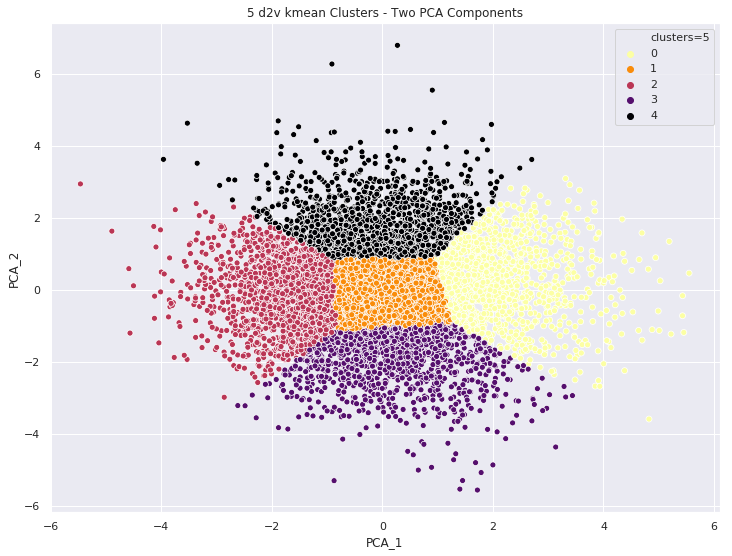


Avg Obs per cluster: 1523.4

Number of observations per cluster:
1    2053
2    1649
4    1433
3    1266
0    1216
dtype: int64
Time: 2.8776841163635254 seconds.

Number of Clusters: 7

Silhouette Score 7 clusters: 0.26674296325103036




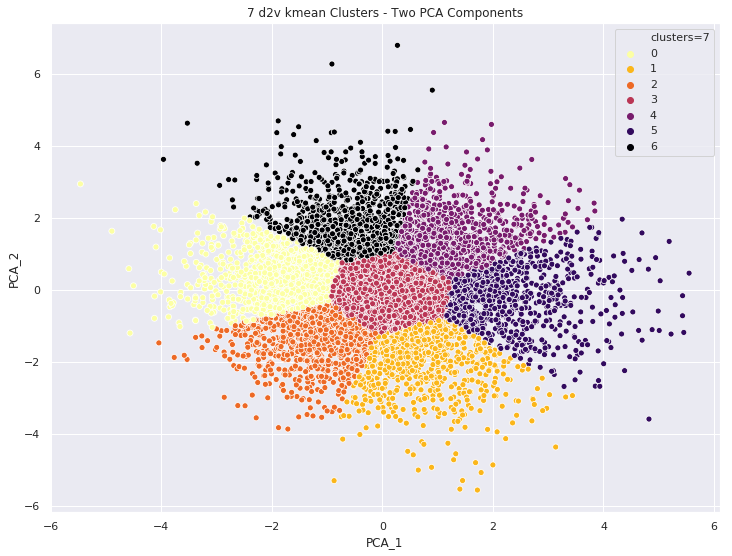


Avg Obs per cluster: 1088.142857142857

Number of observations per cluster:
3    1956
0    1120
2    1006
4     983
6     900
1     859
5     793
dtype: int64
Time: 2.7257933616638184 seconds.

Number of Clusters: 9

Silhouette Score 9 clusters: 0.031988378366310036




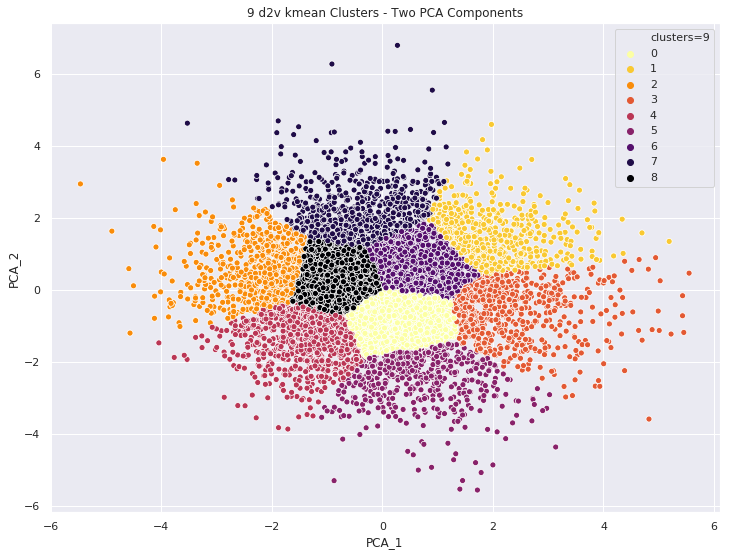


Avg Obs per cluster: 846.3333333333334

Number of observations per cluster:
8    1309
0    1265
6    1096
4     862
7     708
3     655
2     647
1     554
5     521
dtype: int64
Time: 2.8095762729644775 seconds.

Number of Clusters: 10

Silhouette Score 10 clusters: 0.014347804908935634




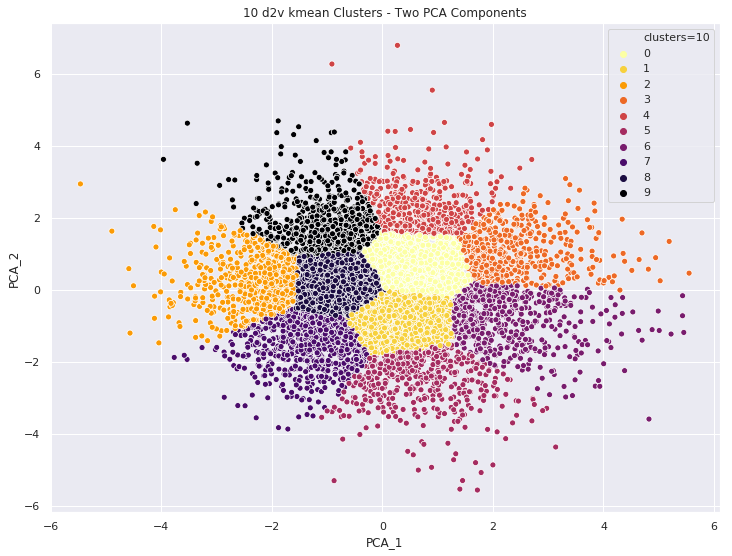


Avg Obs per cluster: 761.7

Number of observations per cluster:
8    1262
1    1196
0    1121
7     796
9     630
2     607
6     577
3     481
5     480
4     467
dtype: int64
Time: 3.4751713275909424 seconds.

Number of Clusters: 11

Silhouette Score 11 clusters: -0.0345399006454891




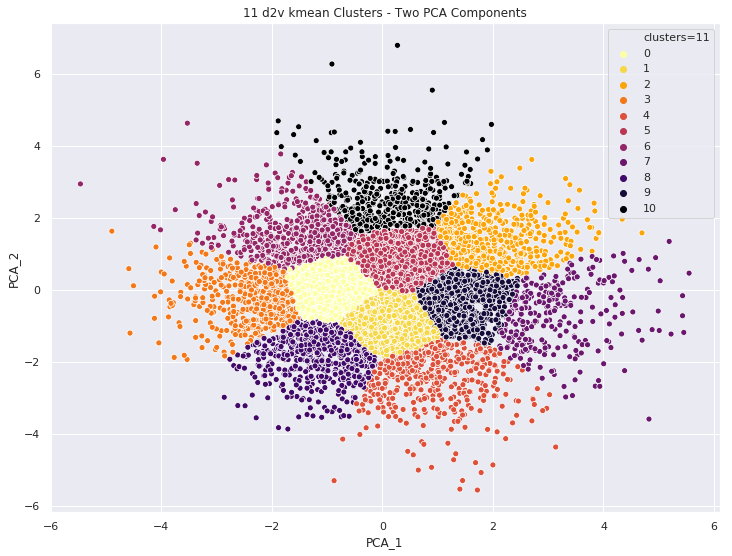


Avg Obs per cluster: 692.4545454545455

Number of observations per cluster:
0     1138
5     1117
1     1091
9      737
8      664
6      578
2      547
3      534
4      473
10     465
7      273
dtype: int64
Time: 3.1294708251953125 seconds.

Number of Clusters: 25

Silhouette Score 25 clusters: -0.27056780340592046




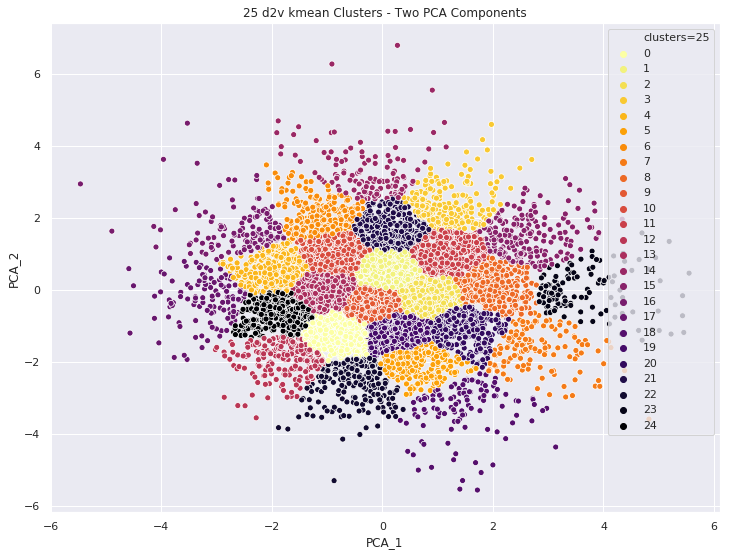


Avg Obs per cluster: 304.68

Number of observations per cluster:
9     574
13    569
1     559
11    461
0     446
2     440
19    427
10    414
21    375
8     346
4     328
24    326
dtype: int64
Time: 3.9850099086761475 seconds.



In [78]:
sns.set_context('notebook')
d2v_clusters = [5,7,9,10,11,25]
for i in d2v_clusters:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=43).fit_predict(Y)    
    print('Number of Clusters: {}'.format(i))
    # calculate and print silhouette average scores
    print('\nSilhouette Score {} clusters:'.format(i), silhouette_score(Y, d2v_clusters, metric='cosine'))
    print('\n')
    pca_d2vclusters['clusters='+str(i)] = d2v_clusters
    plt.figure(figsize=(12,9))
    sns.scatterplot(x='PCA_1', y='PCA_2', hue='clusters='+str(i), data=pca_d2vclusters,palette='inferno_r',legend='full')
    plt.legend(loc='upper right')
    # label the axes and set the chart title  
    plt.title("{} d2v kmean Clusters - Two PCA Components".format(i))   
    plt.show()
    print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
    print('Number of observations per cluster:')
    print(pd.value_counts(d2v_clusters)[:12])    
    t2 = time.time()
    print("Time: {} seconds.\n".format(t2-t1))

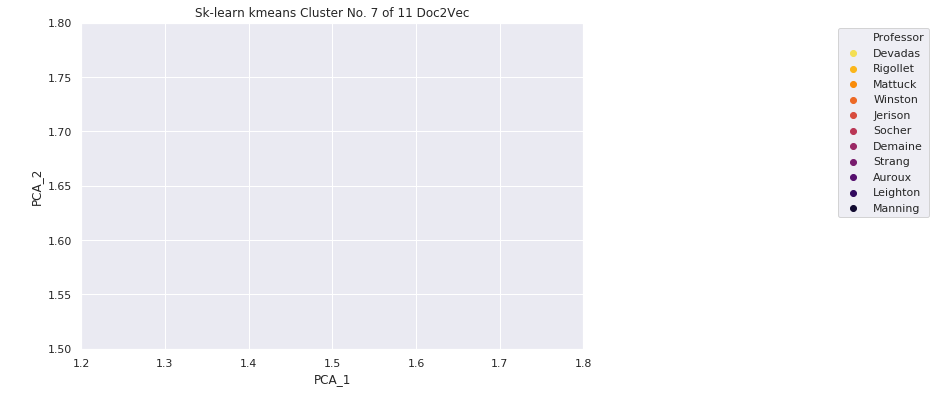

In [79]:
clusterd2v6 = pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='PCA_1',
                y='PCA_2', 
                hue='Professor', 
                data=pca_d2vclusters[pca_d2vclusters['clusters=11'] == 6],
                palette='inferno_r')
for label, x, y in zip(clusterd2v6.original,clusterd2v6.PCA_1,clusterd2v6.PCA_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

#plt.xlim(1.2,1.8)
#plt.ylim(1.5,1.8)
plt.title('Sk-learn kmeans Cluster No. 7 of 11 Doc2Vec')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

So  far we have seen the K means algorithm create clusters of different sizes for both TF-IDF vectorization and Doc2Vec vecotrization.

The results of the silhouette scores were not very good. Many of them were close to zero for my desired clusters (10 or 11).
According to the documentation for sklearn silhouette score:
"Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."

One observation to be made at this point is that the clusters seem to contain sentences that just have similar word use(see above).
How ever the clusters do not seem to line up directly with the similarity scores.
See below for an example.

In [80]:
#display sentences from referenced lecture
d2v_sim['cluster11'] = pca_d2vclusters['clusters=11']
sentence = 'p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.'
d2v_sim[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','cluster11']].sort_values(by=[sentence],ascending=False)[:5]

p statement girl g reject boy b girl g suitor algorithm terminate husband prefer b.  \
6061                                           1.000000                                     
6642                                           0.548204                                     
2441                                           0.543510                                     
3834                                           0.498573                                     
4750                                           0.486362                                     

                                      Original_Sentence Professor  Subject  \
6061  p statement girl g reject boy b girl g suitor ...  Leighton  CS Math   
6642       so girl g bad m tma be mate m let b mate tma  Leighton  CS Math   
2441       there be rogue couple m. b g rogue couple m.  Leighton  CS Math   
3834           and  multiply 2 k  p p plus k 1 minus b.  Leighton  CS Math   
4750  and encounter day girl suitor algorithm stop g...  Leighton  CS Math   

                filenames  cluster11  
6061  leighton7graphmatch         10  
6642  leighton7graphmatch          0  
2441  leighton7graphmatch          5  
3834    leighton19cprobcs          2  
4750  leighton7graphmatch         10

The next step is to define the model and examine each cluster

In order to proceed, we must chose a vectorization method, a clustering method and in our case, number of clusters.
So far the Doc2Vec seems to be doing a better job in terms of vectorization.  When comparing the TFIDF and D2V scatter shapes after PCA to two components, the Doc2Vec has better geometry.  For clustering, the K means algorithm is one of the only algorithms that is viable for this dataset, as it lets me define n_clusters and it is scalable. Other clustering algorithms, resulted in errors as the algorithms consistently determine that one cluster is optimal.
So for now, I have chosen Doc2Vec for vectorization and KMeans clustering for the clustering algorithm. Let's run the KMeans algorithm on the full vectors instead of the PCA version to determine how many clusters we want to define.

In [81]:
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [82]:
#this loop iterates over a range of 10 to 46, in order to collect scores from each cluster
nclusts =[]
sscores = [] 
avgobs = []
obsstd = []
d2v_full = range(10,46,2)
for i in d2v_full:
    t1 = time.time()
    d2v_clusters = cluster.KMeans(n_clusters=i, random_state=42).fit_predict(vecs)    
    nclusts.append(i)
    sscores.append(silhouette_score(vecs, d2v_clusters, metric='cosine'))
    avgobs.append(pd.value_counts(d2v_clusters).mean())
    obsstd.append(pd.value_counts(d2v_clusters).std())
    print('N. Clusters: {}, done!'.format(i))

N. Clusters: 10, done!
N. Clusters: 12, done!
N. Clusters: 14, done!
N. Clusters: 16, done!
N. Clusters: 18, done!
N. Clusters: 20, done!
N. Clusters: 22, done!
N. Clusters: 24, done!
N. Clusters: 26, done!
N. Clusters: 28, done!
N. Clusters: 30, done!
N. Clusters: 32, done!
N. Clusters: 34, done!
N. Clusters: 36, done!
N. Clusters: 38, done!
N. Clusters: 40, done!
N. Clusters: 42, done!
N. Clusters: 44, done!


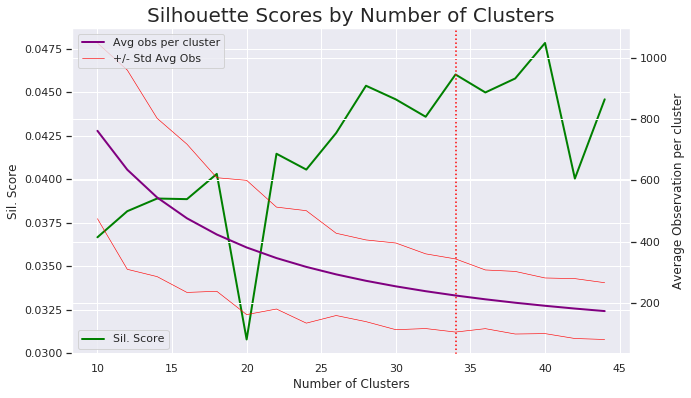

In [83]:
#Visualize Results
obsstd1 = [ i+j for i,j in zip(avgobs,obsstd)]
stdneg = [ i-j for i,j in zip(avgobs,obsstd)]

sns.set_context('notebook')
fig, ax = fig, ax = plt.subplots(figsize=(10,6))

ax2 = ax.twinx()
ax = sns.lineplot(nclusts, sscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(nclusts, avgobs,color='purple',label='Avg obs per cluster', linewidth=2)
sns.lineplot(nclusts,obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
sns.lineplot(nclusts,stdneg,color='r', linewidth=.6)

ax.set_ylabel('Sil. Score')
ax.set_xlabel('Number of Clusters')
ax.axvline(x=34,color='r',linestyle='dotted')
ax.legend(loc='lower left')
ax2.legend(loc='upper left')
plt.ylabel('Average Observation per cluster')
plt.xlabel('Number of Clusters')
plt.title('Silhouette Scores by Number of Clusters',fontsize=20)
#
plt.show()

In this chart we can see that the silhouette scores are pretty volitile (and low). The objective is to pick a cluster number with a relatively high silhouette score and a relatively even distribution of observations per cluster.  The chart seems to indicate that cluster numbers of ~27-34 appear to be stable, and the red bands straddling the purple line indicates lower variance which suggests the distribution observations is evening out.

At this point, I have decided to disregard the pre determined number of clusters (10+11) and elect to use 34 clusters. I chose 34 instead of 40 because of the stability in scores leading up to 34, this decision forgoes a higher score at 40 but avoids the volitility surrounding that point.

Lets reduce the dimensionality use t-SNE, as it is said be good for visualization of texts.

In [84]:
#instantiate TSNE, set up a dataframe for graphing
tsne = TSNE(n_components=2)
tsne_d2v = pd.DataFrame()
tsne_d2v['original'] = X_train
tsne_d2v['Professor'] = y_train[:,0]
tsne_d2v['Subject'] = y_train[:,1]
tsne_d2v['filename'] = y_train[:,2]

Number of Clusters: 34

Silhouette Score: 0.04512994618574246




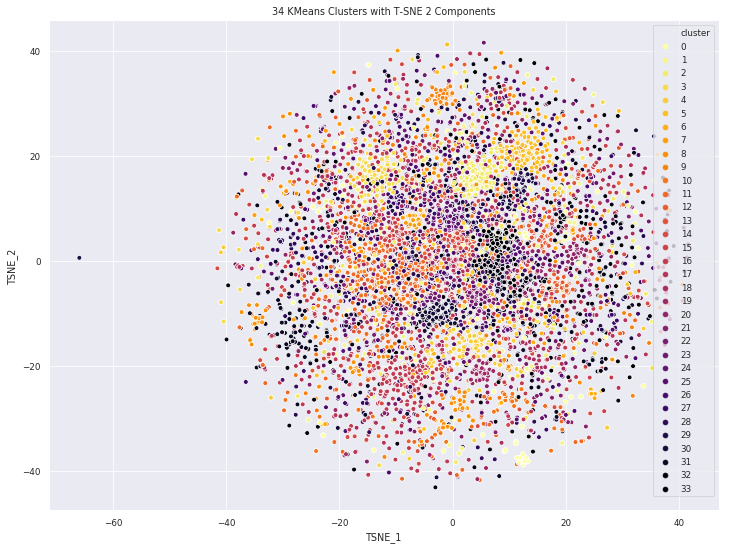


Avg Obs per cluster: 224.02941176470588

Number of observations per cluster:
17    547
11    511
32    433
25    374
29    343
16    333
30    286
31    274
15    267
4     255
8     243
14    242
dtype: int64
Time: 159.57591700553894 seconds.



In [85]:
sns.set_context('paper')

t1 = time.time()
d2v_clusters = cluster.KMeans(n_clusters=34, random_state=43).fit_predict(vecs)    
print('Number of Clusters: 34')
# calculate and print silhouette average scores
print('\nSilhouette Score:', silhouette_score(vecs, d2v_clusters, metric='cosine'))
print('\n')

Yt = tsne.fit_transform(vecs)
tsne_d2v['TSNE_1'] = Yt[:,0]
tsne_d2v['TSNE_2'] = Yt[:,1]
tsne_d2v['cluster'] = d2v_clusters
plt.figure(figsize=(12,9))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='cluster', data=tsne_d2v, palette='inferno_r',legend='full')
plt.legend(loc='upper right')
# label the axes and set the chart title  
plt.title("34 KMeans Clusters with T-SNE 2 Components")
plt.show()
print("\nAvg Obs per cluster: {}\n".format(pd.value_counts(d2v_clusters).mean()))
print('Number of observations per cluster:')
print(pd.value_counts(d2v_clusters)[:12])    
t2 = time.time()
print("Time: {} seconds.\n".format(t2-t1))

In [86]:
tsned2v33 = tsne_d2v[tsne_d2v['cluster'] == 33]
tsned2v33.head()

original Professor  \
19   but edge left right  sum degree left  count nu...  Leighton   
20   well absolute value complex number plus omega ...   Mattuck   
87   and essentially similar vector train model suf...    Socher   
131  but guarantee good sentence wrong number way g...   Manning   
156  for k natural number k random variable r1 r2 r...  Leighton   

                    Subject              filename    TSNE_1     TSNE_2  \
19                  CS Math  leighton6graphtheory -9.795947  18.446255   
20   Differential Equations         mattuckdifeq7  3.441781  -3.195241   
87                      NLP            sochernlp3 -8.664546  29.033970   
131                     NLP          manningnlp10  6.630394   5.649990   
156                 CS Math      leighton21expect  7.824965  25.784065   

     cluster  
19        33  
20        33  
87        33  
131       33  
156       33

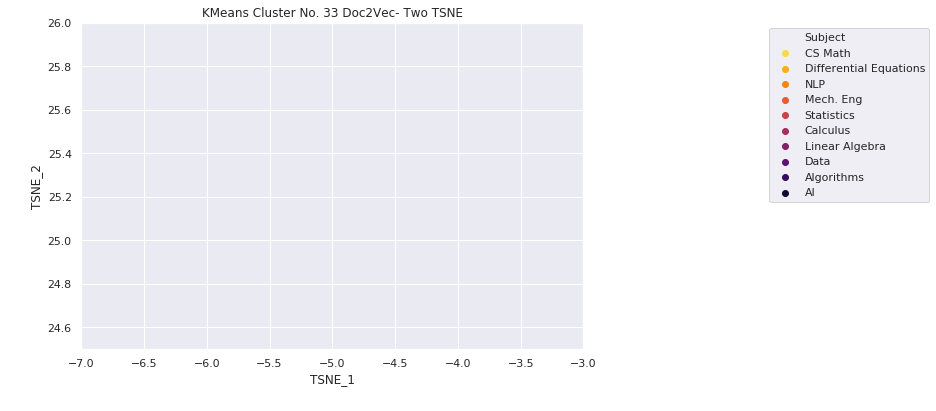

In [87]:
tsned2v33 = tsne_d2v[tsne_d2v['cluster'] == 33]
plt.figure(figsize=(9,6))
sns.set_context('notebook')
sns.scatterplot(x='TSNE_1',
                y='TSNE_2', 
                hue='Subject', 
                data=tsned2v33,
                palette='inferno_r')
for label, x, y in zip(tsned2v33.original,tsned2v33.TSNE_1,tsned2v33.TSNE_2):
    plt.annotate(label, xy=(x, y), xytext=(7, 2), textcoords='offset points',fontsize=10)

#plt.xlim(-7,-3)
#plt.ylim(24.5,26)
plt.title('KMeans Cluster No. 33 Doc2Vec- Two TSNE')
plt.legend(bbox_to_anchor=[1.7,1],loc='upper right')
plt.show() 

plt.show()

### Intracluster similarity of sentences
It still is not clear how the algorithm is clustering. We need to look at each cluster and examine how similar it's sentences are to each other. To do this we will use the cosine similarity matrix to calculate the intracluster similarity of each sentence Then we will visually inspect the results to determine any patterns, topics etc.

In [88]:
#We need to add the cluster numbers to the vecs dataframe
subsprofs = pd.DataFrame(y_train)
subsprofs['cluster_no'] = d2v_clusters
vecs['cluster_no'] = d2v_clusters
for_sims = pd.DataFrame(X_train)
for_sims['cluster_no'] = d2v_clusters

In [89]:
# this function iterates over clusters and calculates the average cosine similarity score of sentences
#For each cluster, a dictionary stores cluster level information as keys and returns a data frame
#with the 'num_sents'(int) most related sentences as rows and the lecture source and intracluster mean similarity
#as columns
n_clusters = 34
def get_similarities(num_sents):    
    sim_sents = OrderedDict()
    lects = OrderedDict()
    mean_sims = {}
    
    # iterate over clusters
    for i in range(n_clusters):
        tmpdf = vecs[vecs.cluster_no == i]
        tmpdf = tmpdf.drop(['cluster_no'],1)
        tmp1 = for_sims[for_sims.cluster_no == i ]
        tmp1 = tmp1.drop(['cluster_no'],1)
        # calculate cosine similarity with Sklearn's cosine_similarity method and store in dataframe
        df_sim = pd.DataFrame(cosine_similarity(tmpdf), index=range(len(tmp1)), columns=tmp1)          
        # insert a column with the average similarity score of each row in the similarity matrix
        df_sim.insert(0, 'mean_similarity', df_sim.mean(axis=1)) 
        df_sim.insert(0, 'lecture', subsprofs[subsprofs.cluster_no == i][2].reset_index(drop=True))
        df_sim.insert(0, 'original_sentence', tmp1.reset_index(drop=True))
        # calculate the cluster's global average similarity score
        mean_similarity = df_sim.mean_similarity.mean()        
        # store the cluster's global average similarity score in a dictionary
        mean_sims['cluster {}'.format(i)] = mean_similarity
        mean_sims['cluster {}'.format(i)] = mean_similarity
        #the DataFrame will be the dictionary value
        top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]
        # store the most similar sentence and the average similarity score of clusters
        sim_sents['cluster_{} | {} sentences | mean similarity: {}'.format(
            i, df_sim.shape[0], mean_similarity)] = top_sents

    return sim_sents, mean_sims

In [90]:
#call the function for 10 sentences per cluster
ten_sents, mean_sims = get_similarities(10)

In [91]:
#For each cluster, examine the top 10 most similar sentences in each cluster, along with the source
for i in ten_sents:
    vals = ten_sents[i]
    print('\n{}'.format(i))
    print('\nOriginal Sentence\n\n{}\n\nLecture\n\n{}\\nnMean_sim\n\n{}'.format(
        vals.original_sentence,vals.lecture,vals.mean_similarity))


cluster_0 | 163 sentences | mean similarity: 0.25214190622544097

Original Sentence

13              so probability b give a b precede a time
48                      b a b. a event  choose fair coin
18     well probability b a probability a.  compute p...
22     first probability a give b probability a b hap...
119       the probability a give b probability b give a.
77           so probability a give b probability a b p 2
151    when probability a give b equal probability b ...
23                  so roll twice odd get good a beat b.
162                             if  reverse step a r a  
125    the product rule say probability a b event equ...
Name: original_sentence, dtype: object

Lecture

13     leighton19cprobcs
48     leighton19cprobcs
18     leighton19cprobcs
22       leighton20indcs
119    leighton19cprobcs
77     leighton19cprobcs
151    leighton19cprobcs
23      leighton18csprob
162           strangLA10
125    leighton19cprobcs
Name: lecture, dtype: object\nnMean_sim

13  

## Assessing the clusters
 - After calculating the intercluster similarities, some real patterns have started to emerge.
     - The clusters appear to exhibit the same characteristics as before (ie identifying the same word use in different sentences) however, with 34 clusters (we looked at 10, 11 before) some clusters seem to have more relavent similar sentences, even topics. For example, the topic of cluster 33 is clearly probability, not only do the sentences suggest it, but the sentence sources suggest it could be the 'topic' of the cluster. (other sentences pertaining to probability also show up in other clusters) Other clusters on the other hand do not share this 'topic' characteristic.  For instance cluster 25 is a eclectically sourced collection of sentences starting with the word 'but'.


#### Examining Word Frequencies
     - By extracting the word frequencies and subject/professor/lecture density of each cluster, maybe we can draw new insight.

In [92]:
#this function removes any 's in the text, tokenizes and stems the word
def clean_lite (text):
    re.sub(" 's",'',text)
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if len(word) > 3]
    words = [word for word in words if word not in default_stopwords]
    #words = [stemmer.stem(word) for word in words]
    return words    

In [93]:
#add the sentences to our previous dataframe
subsprofs[3] = X_train

In [94]:
subsprofs.head()

0           1                2  cluster_no  \
0  Rigollet  Statistics   rigolletstats3          30   
1   Devadas  Algorithms    devadasalgos4          31   
2   Devadas  Algorithms   devadasalgos10          27   
3   Devadas  Algorithms    devadasalgos1           0   
4  Rigollet  Statistics  rigolletstats13          14   

                                                   3  
0  and non parametric estimation typically actual...  
1  now discard node n heap simply decrement heap ...  
2  so probabilistic argument assume hash function...  
3  then guess 2d peak great equal b great equal d...  
4  then  say  want y plus bx  go add noise epsilo...

In [95]:
#iterate over each cluster, 
#convert all sentences in each cluster to one str
#tokenize, stem words, count frequencies
for i in sorted(subsprofs.cluster_no.unique()):
    #iterate by cluster
    cluster_df = subsprofs[subsprofs.cluster_no == i].reset_index(drop=True)
    #Make one large string
    cluster_str = ' '.join([ ' '.join([i]) for i in cluster_df[3]]) 
    #run lite cleaner
    cluster_str = clean_lite(cluster_str)
    
    fdist = nltk.FreqDist(cluster_str)
    freq_words = list(Counter(fdist).most_common(5))
    profs = Counter(dict(cluster_df[0].value_counts())).most_common(5)
    subs = Counter(dict(cluster_df[1].value_counts())).most_common(5)
    lects = Counter(dict(cluster_df[2].value_counts())).most_common(5)
    print('Cluster Number: {}, Sentences: {}\n Words and Counts:{}\n Professors: {}\n Subjects:{}\n Lectures: {}\n'.format(\
        i,cluster_df.shape[0],freq_words,profs,subs, lects))

Cluster Number: 0, Sentences: 163
 Words and Counts:[('probability', 52), ('give', 31), ('column', 30), ('equal', 24), ('time', 21)]
 Professors: [('Strang', 56), ('Leighton', 49), ('Mattuck', 10), ('Demaine', 9), ('Auroux', 9)]
 Subjects:[('CS Math', 49), ('Linear Algebra', 45), ('Calculus', 13), ('Mech. Eng', 11), ('Differential Equations', 10)]
 Lectures: [('leighton19cprobcs', 20), ('strangLA10', 11), ('strangLA3', 10), ('leighton20indcs', 9), ('strangLA1', 7)]

Cluster Number: 1, Sentences: 112
 Words and Counts:[('equation', 126), ('zero', 30), ('solve', 24), ('solution', 18), ('equal', 17)]
 Professors: [('Mattuck', 41), ('Strang', 40), ('Auroux', 8), ('Manning', 7), ('Leighton', 5)]
 Subjects:[('Differential Equations', 41), ('Linear Algebra', 22), ('Mech. Eng', 18), ('Calculus', 12), ('NLP', 8)]
 Lectures: [('mattuckdifeq9', 11), ('mattuckdifeq3', 8), ('mattuckdifeq4', 8), ('manningnlp8', 6), ('strangmeng2', 6)]

Cluster Number: 2, Sentences: 232
 Words and Counts:[('right', 2

Cluster Number: 19, Sentences: 119
 Words and Counts:[('different', 134), ('time', 11), ('like', 11), ('look', 10), ('kind', 10)]
 Professors: [('Socher', 34), ('Leighton', 16), ('Rigollet', 14), ('Strang', 13), ('Demaine', 13)]
 Subjects:[('NLP', 42), ('CS Math', 16), ('Statistics', 14), ('Data', 13), ('Algorithms', 10)]
 Lectures: [('sochernlp3', 12), ('sochernlp13', 10), ('sochernlp16', 8), ('leighton20indcs', 7), ('sochernlp5', 4)]

Cluster Number: 20, Sentences: 154
 Words and Counts:[('right', 21), ('equal', 16), ('probability', 14), ('time', 14), ('look', 14)]
 Professors: [('Rigollet', 43), ('Leighton', 34), ('Winston', 15), ('Strang', 14), ('Jerison', 9)]
 Subjects:[('Statistics', 43), ('CS Math', 34), ('AI', 15), ('NLP', 15), ('Calculus', 12)]
 Lectures: [('rigolletstats8', 8), ('leighton18csprob', 8), ('leighton7graphmatch', 7), ('rigolletstats21', 7), ('leighton6graphtheory', 5)]

Cluster Number: 21, Sentences: 203
 Words and Counts:[('equal', 65), ('plus', 54), ('time', 25

After examing the occurance frequencies of each tokens and their identifying labels, we see some support for our hypothesis. For instance the word probability occurs 184 times, while the next common word is 'equal' with 21 counts. In fact 19 of the 34 clusters have a word that is present at least more than 4 four times than the second most frquently occuring word, in some clusters that rate is almost 10.
 - Clusters with dominant words:
     - 1,3,5,6,7,8,10,14,15,16,19,20,21,24,26,28,30,32,33
 - Clusters with out dominant words include those not listed above. The most common words occur at a rate less than 2 twice the second word, and do not really seem to be related to any particular topic. The word 'actually' shows up alot.
 -  A last observation is the similarities between clusters 30 and 32 where the 2 most common words are 'need' and 'know' - and - 'know' and 'want'. As in 'i need to know x, once i have x i want to y'
 
While this analysis shed some light on new patterns not seen before, we can use another technique called NonNegative Matrix Factorization. We will apply a minMax scaler to that data move all the data points positive between 0 and 1. then for each cluster we will apply the fit and see how the sentences are groups. This is a common way of finding subtopics with clusters.

In [97]:
#define a function to extract subtopics

def nmf_topics(vec_matrix, num_sents):
    sim_sents = OrderedDict()
    
    for i in range(n_clusters):
        tmp1 = subsprofs[subsprofs.cluster_no == i]
        temp_matrix = vecs
        temp_matrix['cluster_no'] = subsprofs.cluster_no
        temp_matrix = temp_matrix[temp_matrix.cluster_no == i]
        temp_matrix = minmax_scale(temp_matrix.drop(['cluster_no'],1))
        n_comps = int(np.ceil(temp_matrix.shape[0] * .01)) #70 sentences per component
        #Instaniate a NMF instance 

        nmf = NMF(alpha=0.35, 
                  init='nndsvd', # how starting value are calculated
                  l1_ratio=0.7, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
                  max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
                  n_components=n_comps, 
                  random_state=0, 
                  solver='cd', # Use Coordinate Descent to solve
                  tol=0.0001, # model will stop if tfidf-WH <= tol
                  verbose=1) # amount of output to give while iterating
        components = nmf.fit_transform(temp_matrix)
        df_components = pd.DataFrame(components, index=tmp1[[2,3]])
        df_components.insert(0, 'sentence',tmp1[3])
        df_components.insert(0, 'lecture',tmp1[2].reset_index(drop=True))
                                    
        for col in df_components.columns[2:]:
            top_sents = df_components[col].sort_values(ascending=False)[:num_sents].index
            sim_sents['cluster_{}, component {}'.format(i, col)] = top_sents
        
        print('Cluster {}: {} observations , {} components'.format(i, temp_matrix.shape[0],n_comps))
    
    return sim_sents



In [98]:
#Call the function
cluster_topics = nmf_topics(vecs, 5)

violation: 1.0
violation: 0.31749641260743255
violation: 0.22474751108989022
violation: 0.18465898003598316
violation: 0.1514612429265233
violation: 0.12700990855281316
violation: 0.11065745262805106
violation: 0.09759106394638473
violation: 0.08650587197605575
violation: 0.07720543143611838
violation: 0.06947684405347725
violation: 0.06333962786709041
violation: 0.058395660804717406
violation: 0.054479901417283975
violation: 0.05149004353973367
violation: 0.049200939141303315
violation: 0.04743849877080787
violation: 0.045961151887456954
violation: 0.044616891385957425
violation: 0.04341383827154966
violation: 0.04240436403553999
violation: 0.041460977011870334
violation: 0.040528044601106185
violation: 0.03965988309798611
violation: 0.03885519586462879
violation: 0.0380823199978429
violation: 0.03734255782457727
violation: 0.036630753598875875
violation: 0.035941336703891553
violation: 0.035265487222312854
violation: 0.034629107592555886
violation: 0.03398864065612094
violation: 0.03

violation: 0.0005151617939065642
violation: 0.0005059232119417984
violation: 0.0004968502936732456
violation: 0.0004879400689760204
violation: 0.00047918962094531815
violation: 0.0004705960849933652
violation: 0.00046215664783432923
violation: 0.00045386854665904405
violation: 0.00044572906814805617
violation: 0.00043773554758727253
violation: 0.0004298853681576199
violation: 0.00042217595968564535
violation: 0.0004146048157315545
violation: 0.00040716951314823677
violation: 0.00039986753973428866
violation: 0.000392696505154022
violation: 0.0003856540616629069
violation: 0.0003787379038306592
violation: 0.0003719457674183682
violation: 0.0003652754288075795
violation: 0.00035872470430649484
violation: 0.0003522914492682862
violation: 0.00034597355741643356
violation: 0.0003397689604316189
violation: 0.0003336756268829311
violation: 0.00032769156189490356
violation: 0.00032181480623498824
violation: 0.0003160434358692769
violation: 0.00031037557179022443
violation: 0.000304809347555478

violation: 0.0002560854273223597
violation: 0.000249889088079912
violation: 0.00024394020387669694
violation: 0.00023816847774346043
violation: 0.00023256621256651243
violation: 0.00022712617576502801
violation: 0.00022184156679681924
violation: 0.00021670598692758326
violation: 0.00021171341107536487
violation: 0.0002068587061275015
violation: 0.00020213598915147098
violation: 0.00019754013244607536
violation: 0.00019306636989464127
violation: 0.00018871019626053286
violation: 0.00018446734955341633
violation: 0.00018033379446671813
violation: 0.00017630609376233946
violation: 0.0001723803547893415
violation: 0.0001685529671644706
violation: 0.0001648206643368853
violation: 0.00016118034038311563
violation: 0.0001576290395415652
violation: 0.0001541639466644747
violation: 0.00015078237820286472
violation: 0.0001474817738271467
violation: 0.00014425980913487058
violation: 0.00014111404280618282
violation: 0.00013804247671317897
violation: 0.00013504288527546528
violation: 0.00013211299

violation: 0.0005380133844183605
violation: 0.0005302400239879724
violation: 0.0005225789305090386
violation: 0.0005150284838994805
violation: 0.0005075870874240008
violation: 0.0005002531672908244
violation: 0.0004930251724623816
violation: 0.0004859015741875674
violation: 0.00047888086579937056
violation: 0.00047196156224969615
violation: 0.00046514219999264765
violation: 0.0004584213365413854
violation: 0.0004517975501437652
violation: 0.0004452694395878166
violation: 0.0004388356238583046
violation: 0.00043249474183955816
violation: 0.000426245452057619
violation: 0.0004200864323061095
violation: 0.000414016379463803
violation: 0.0004080340092875032
violation: 0.00040213805591496
violation: 0.0003963272718968939
violation: 0.0003906004275182277
violation: 0.00038495631104255574
violation: 0.0003793937280867724
violation: 0.000373911501533809
violation: 0.00036850847116875357
violation: 0.0003631834967040667
violation: 0.00035793544791873664
violation: 0.0003527632141067986
violatio

Cluster 3: 206 observations , 3 components
violation: 1.0
violation: 0.2887925717767984
violation: 0.155936481254519
violation: 0.12057457671127368
violation: 0.10692314023331755
violation: 0.09889181624206039
violation: 0.0932999882532452
violation: 0.08940044886462356
violation: 0.0859217117220617
violation: 0.08164543706075675
violation: 0.07860307122311942
violation: 0.07607441439118576
violation: 0.07442640639851818
violation: 0.0729990027799388
violation: 0.07184729945325577
violation: 0.07081425278881541
violation: 0.06970414001244984
violation: 0.06887720361403095
violation: 0.06800660213665403
violation: 0.0671468230225094
violation: 0.0662633151029415
violation: 0.0653014906669607
violation: 0.06441359820185183
violation: 0.06336825973324148
violation: 0.06245211042574779
violation: 0.061600204396866594
violation: 0.06071628938083642
violation: 0.06007405561389062
violation: 0.05906980536645809
violation: 0.058198748413584085
violation: 0.057390600880044274
violation: 0.05648

violation: 0.048275000668301024
violation: 0.04746956287827339
violation: 0.04667805236077469
violation: 0.04590026708823857
violation: 0.04513590006493927
violation: 0.044384620747090105
violation: 0.04364624849633165
violation: 0.04292051555896725
violation: 0.0422071601339435
violation: 0.041505937715616774
violation: 0.04081659888719202
violation: 0.04013890708518531
violation: 0.03947269257924228
violation: 0.03881772434970036
violation: 0.03817378780542219
violation: 0.03754069747639052
violation: 0.0369181903916325
violation: 0.03630611048028779
violation: 0.03570429984173547
violation: 0.0351125092779318
violation: 0.0345305989634968
violation: 0.033958358325361156
violation: 0.033395664059165865
violation: 0.032842343296428184
violation: 0.03229819519058852
violation: 0.03176308136496159
violation: 0.0312368457590882
violation: 0.03071933151612995
violation: 0.030210401624472753
violation: 0.029709882781780304
violation: 0.029217655826426197
violation: 0.02873356048497108
viol

violation: 0.0023024127364283803
violation: 0.00223979805914621
violation: 0.0021788860435320457
violation: 0.0021196303981901583
violation: 0.0020619860897274963
violation: 0.002005909308799189
violation: 0.0019513574367463888
violation: 0.0018982890131145358
violation: 0.0018466637046316468
violation: 0.0017964422739527434
violation: 0.001747586550445213
violation: 0.0017000594010987808
violation: 0.0016538247019302556
violation: 0.0016088473111139344
violation: 0.0015650930420913925
violation: 0.0015225286374952569
violation: 0.0014811217440009383
violation: 0.0014408408878687868
violation: 0.0014016554509007878
violation: 0.0013635356471848486
violation: 0.001326452500577042
violation: 0.0012903778227215577
violation: 0.001255284191447248
violation: 0.0012211449302275141
violation: 0.0011879340876945511
violation: 0.0011556264180143253
violation: 0.0011241973616353857
violation: 0.001093623026891447
violation: 0.0010638801714637342
violation: 0.0010349461851130828
violation: 0.0010

violation: 0.042537224015574374
violation: 0.041583275254045
violation: 0.04068036069816529
violation: 0.03980535873582414
violation: 0.03852753360557899
violation: 0.037389155462744406
violation: 0.036277101439054465
violation: 0.035221972196100224
violation: 0.034359504483887825
violation: 0.03354664003021947
violation: 0.03276820514785199
violation: 0.032035490632315346
violation: 0.031324023627615986
violation: 0.030574756010913272
violation: 0.02992650344661436
violation: 0.029262887603257237
violation: 0.028634380490395975
violation: 0.028037988186397397
violation: 0.027473103896186995
violation: 0.026929691141430914
violation: 0.026407892155010316
violation: 0.02590944897290746
violation: 0.02542776600828024
violation: 0.02495982724012175
violation: 0.024503227720178232
violation: 0.024057739410540645
violation: 0.0236233175034371
violation: 0.023199766687826667
violation: 0.022787336380041816
violation: 0.022386753490707723
violation: 0.021995054361404396
violation: 0.021611735

violation: 0.0039890542137975835
violation: 0.003912679803965735
violation: 0.0038377666739409593
violation: 0.0037642869012979984
violation: 0.0036922130959104187
violation: 0.0036215183896123235
violation: 0.0035521764265718436
violation: 0.003484161353366736
violation: 0.003417447809478408
violation: 0.0033520109181041247
violation: 0.0032878262767990904
violation: 0.0032248699484400747
violation: 0.0031631184526188134
violation: 0.0031025487566801483
violation: 0.0030431382674651858
violation: 0.002984864822823145
violation: 0.0029277066833525937
violation: 0.002871642524628259
violation: 0.0028166514291039983
violation: 0.0027627128783667696
violation: 0.0027098067455803483
violation: 0.0026579132882628646
violation: 0.002607013140544642
violation: 0.0025570873063730376
violation: 0.0025081171522421644
violation: 0.00246008440056817
violation: 0.0024129711225846957
violation: 0.002366759731938282
violation: 0.0023214329780840036
violation: 0.002276973939868289
violation: 0.0022333

violation: 0.0001636555773801697
violation: 0.00016057058609725256
violation: 0.0001575437465020939
violation: 0.0001545739625543386
violation: 0.00015166015877479075
violation: 0.00014880128004920336
violation: 0.00014599629113946843
violation: 0.00014324417621040908
violation: 0.0001405439387133387
violation: 0.00013789460080977195
violation: 0.00013529520302447336
violation: 0.00013274480410489664
violation: 0.0001302424804556008
violation: 0.0001277873259068174
violation: 0.00012537845140050835
violation: 0.00012301498449710478
violation: 0.00012069606939231321
violation: 0.00011842086626960213
violation: 0.00011618855121221044
violation: 0.00011399831583134249
violation: 0.00011184936691854601
violation: 0.00010974092625514195
violation: 0.00010767223032987797
violation: 0.00010564252986136601
violation: 0.00010365108992889765
violation: 0.00010169718925311921
violation: 9.978012034262471e-05
Converged at iteration 327
Cluster 10: 142 observations , 2 components
violation: 1.0
vio

Cluster 11: 511 observations , 6 components
violation: 1.0
violation: 0.2846807664831309
violation: 0.22106447273603277
violation: 0.18187142148875884
violation: 0.14328463515560555
violation: 0.10854386232931235
violation: 0.08323692167182521
violation: 0.0663232165985546
violation: 0.05331666202899438
violation: 0.04291072234495232
violation: 0.035365287931647414
violation: 0.03019852202699494
violation: 0.02685640726361563
violation: 0.024686040468749764
violation: 0.023205535892489776
violation: 0.021973334992197332
violation: 0.021135241475258273
violation: 0.02041621018255035
violation: 0.019787493404082743
violation: 0.01922430075638475
violation: 0.018703940529272545
violation: 0.018219848482089226
violation: 0.017765797014252523
violation: 0.017339015189437118
violation: 0.016941048054991015
violation: 0.01656001003080477
violation: 0.016198567286845225
violation: 0.015850906044315275
violation: 0.015508952740960669
violation: 0.015118741700058438
violation: 0.0147905038304772

violation: 0.00012201688232759054
violation: 0.00011951777644872709
violation: 0.00011706985572880876
violation: 0.00011467207176095599
violation: 0.00011232339782992203
violation: 0.00011002282801442407
violation: 0.00010776937712882866
violation: 0.00010556208013498581
violation: 0.00010339999175964783
violation: 0.00010128218610846181
violation: 9.920775621136676e-05
Converged at iteration 259
Cluster 13: 119 observations , 2 components
violation: 1.0
violation: 0.2722715833251801
violation: 0.13577368574738738
violation: 0.10984725236173432
violation: 0.10058693330844734
violation: 0.09533270931724079
violation: 0.09122271872323925
violation: 0.08764515507852612
violation: 0.08468055783906599
violation: 0.08252945276331869
violation: 0.08059176550764735
violation: 0.07892295881602594
violation: 0.07702741590141043
violation: 0.07538083595152374
violation: 0.07368879460402844
violation: 0.0719807359365673
violation: 0.0699882964065142
violation: 0.06796151421742955
violation: 0.0659

violation: 0.2887005804514232
violation: 0.15980706599663966
violation: 0.14750227482795142
violation: 0.13025994358640658
violation: 0.10905882412470225
violation: 0.09513610886115184
violation: 0.08802781652621162
violation: 0.08459836519152804
violation: 0.0823693735811517
violation: 0.08040481243912195
violation: 0.07879888907013853
violation: 0.0772586684367359
violation: 0.07585597550102197
violation: 0.07466347555083261
violation: 0.07331584994076347
violation: 0.07223894128374089
violation: 0.07120847842628533
violation: 0.07025816885390526
violation: 0.06935794529287875
violation: 0.06848202960686389
violation: 0.06762559856788425
violation: 0.06682541959088262
violation: 0.0658224306836288
violation: 0.06485091411751065
violation: 0.06394739411203203
violation: 0.06308453084544786
violation: 0.062259982915580825
violation: 0.06146332869553405
violation: 0.0606167699599529
violation: 0.05979356643526157
violation: 0.05898937523892687
violation: 0.058195377681534
violation: 0.0

violation: 1.0
violation: 0.25943345653026945
violation: 0.15750002759648568
violation: 0.12975155835960298
violation: 0.11502316739162577
violation: 0.10535244620427547
violation: 0.09546554125901051
violation: 0.08726886684473607
violation: 0.08094549058513142
violation: 0.07684191599747417
violation: 0.07423026954693465
violation: 0.07231605954513734
violation: 0.07110162612202277
violation: 0.0700801095238872
violation: 0.06935790600744755
violation: 0.06845775396518314
violation: 0.06785267428137982
violation: 0.06707017296919503
violation: 0.06608442950661983
violation: 0.06543917480412047
violation: 0.0647395029534877
violation: 0.06406842553295315
violation: 0.06342036010054988
violation: 0.062375793389062614
violation: 0.061213505075835395
violation: 0.059582442513460634
violation: 0.05851824008815108
violation: 0.05743222738592232
violation: 0.056338732794771945
violation: 0.05524176811197478
violation: 0.054329889569509134
violation: 0.05346847254667965
violation: 0.05280956

violation: 1.0
violation: 0.23764619092237627
violation: 0.14833967129475673
violation: 0.11846294644631146
violation: 0.10007814960070925
violation: 0.08937811848850997
violation: 0.08172445488732914
violation: 0.07644268768239226
violation: 0.07227992065045823
violation: 0.06857645889558955
violation: 0.06590081222991412
violation: 0.06376533059597722
violation: 0.06195932968660533
violation: 0.060445972146028655
violation: 0.059244465949175054
violation: 0.058216287176768765
violation: 0.057423432678200576
violation: 0.05695967928379066
violation: 0.05650315020050221
violation: 0.05619222434983397
violation: 0.056174524305046866
violation: 0.056153335598031325
violation: 0.056328028954529
violation: 0.056702516544275106
violation: 0.056994535088901704
violation: 0.05731016221328566
violation: 0.05765802070231715
violation: 0.057902374540415885
violation: 0.057718690869712944
violation: 0.057573370201956
violation: 0.05693284109205828
violation: 0.05608210724231812
violation: 0.05516

violation: 0.002401317973730668
violation: 0.0023767537623119914
violation: 0.002352445406350686
violation: 0.002328391026104093
violation: 0.002304588238225414
violation: 0.0022810345243608468
violation: 0.0022577271994127044
violation: 0.002234664058722679
violation: 0.0022118426651223135
violation: 0.002189260569920517
violation: 0.0021669235450622213
violation: 0.002144899689899027
violation: 0.0021232002223587464
violation: 0.0021017158924465664
violation: 0.0020804379287321065
violation: 0.0020593701513538535
violation: 0.002038515254987639
violation: 0.002017874233341817
violation: 0.001997447128770933
violation: 0.0019772328622086302
violation: 0.001957230250519425
violation: 0.0019374380526914015
violation: 0.0019178536081102286
violation: 0.0018984750012036142
violation: 0.0018793001570570334
violation: 0.0018603272933624179
violation: 0.001841554220654839
violation: 0.0018229788680896848
violation: 0.0018045991312499695
violation: 0.0017864136102969613
violation: 0.001768420

violation: 0.0005388937410404661
violation: 0.0005301668977167231
violation: 0.0005215813497211085
violation: 0.0005131348102732191
violation: 0.0005048250294954121
violation: 0.000496649793859222
violation: 0.0004886069258484745
violation: 0.00048069428294997453
violation: 0.00047290975735065927
violation: 0.00046525127545191607
violation: 0.00045771679696027533
violation: 0.0004503043148568432
violation: 0.00044301185437750173
violation: 0.0004358374728499687
violation: 0.00042877925883678036
violation: 0.00042183533205225745
violation: 0.0004150038425219597
violation: 0.000408282970130805
violation: 0.00040167092427926914
violation: 0.0003951659433800203
violation: 0.0003887662942251258
violation: 0.0003824702717531535
violation: 0.0003762761984433898
violation: 0.0003701824239872536
violation: 0.0003641873245860142
violation: 0.0003582893029716938
violation: 0.0003524867875094455
violation: 0.00034677823209236367
violation: 0.00034116211562513197
violation: 0.0003356369415788414
vi

violation: 0.00021387751294276445
violation: 0.00019889956734102027
violation: 0.00018441443795444182
violation: 0.00017345350529651785
violation: 0.00016336144256533358
violation: 0.00015405108421129182
violation: 0.00014538841728319678
violation: 0.0001372680489162972
violation: 0.0001296458621232012
violation: 0.000122514021542485
violation: 0.0001158001427248236
violation: 0.00010948095771571171
violation: 0.00010352891793521893
violation: 9.791925451219723e-05
Converged at iteration 391
Cluster 19: 119 observations , 2 components
violation: 1.0
violation: 0.28193974852821646
violation: 0.1101890894196001
violation: 0.08753698803102448
violation: 0.07652333977102085
violation: 0.0695998916377637
violation: 0.06568844700033857
violation: 0.06336337464091565
violation: 0.06169643044947654
violation: 0.06025375447886708
violation: 0.05895097377347192
violation: 0.0577677964590535
violation: 0.05676353190339253
violation: 0.05585131138450612
violation: 0.054977124421720265
violation: 0

violation: 0.00991954087210789
violation: 0.009751286509760978
violation: 0.009585878161375303
violation: 0.009423267595368094
violation: 0.009263407422178425
violation: 0.00910625237941891
violation: 0.008951757198681666
violation: 0.008799876063192793
violation: 0.008650566184443743
violation: 0.008503781600717474
violation: 0.008359504570818925
violation: 0.008217680848479077
violation: 0.008078254779472965
violation: 0.007941185123235227
violation: 0.007806432220394623
violation: 0.0076739570819813014
violation: 0.0075437213775943895
violation: 0.007415688798431
violation: 0.007289823529723392
violation: 0.007166089130738053
violation: 0.007044451890724131
violation: 0.0069248716357364635
violation: 0.0068073158622379
violation: 0.006691748596467816
violation: 0.006578138264853169
violation: 0.00646645211231932
violation: 0.006356660476445448
violation: 0.006248728178579061
violation: 0.006142622915624526
violation: 0.006038313354162913
violation: 0.005935768495151027
violation: 0.

violation: 0.004931076947910052
violation: 0.004846803494078367
violation: 0.00476401919489693
violation: 0.004682665917304072
violation: 0.004602710303946947
violation: 0.004524173286536147
violation: 0.004447013210888495
violation: 0.004371177425543874
violation: 0.0042966372929035485
violation: 0.004223370462293827
violation: 0.004151388901542938
violation: 0.0040806482189020684
violation: 0.004011112349633206
violation: 0.003942760774360433
violation: 0.003875573325806405
violation: 0.003809530182691611
violation: 0.003744611863294417
violation: 0.0036807992192245346
violation: 0.0036180734294636433
violation: 0.003556415994488097
violation: 0.003495808730583463
violation: 0.0034362337641997377
violation: 0.003377673526508748
violation: 0.0033201107479426464
violation: 0.003263528453191342
violation: 0.0032079099559888355
violation: 0.0031524413295380142
violation: 0.003096368941759407
violation: 0.0030422800203560576
violation: 0.002989323252962871
violation: 0.0029373661661831643

violation: 0.00018486573766893368
violation: 0.00018139350804088523
violation: 0.0001779869577174714
violation: 0.00017464481725335717
violation: 0.0001713658434494941
violation: 0.00016814881840221285
violation: 0.00016499254925603338
violation: 0.00016189590386960469
violation: 0.00015885778212664273
violation: 0.00015587698894646104
violation: 0.000152952426061537
violation: 0.00015008299666278583
violation: 0.00014726768654334715
violation: 0.0001445054604780856
violation: 0.0001417952938223037
violation: 0.00013913617201600118
violation: 0.00013652710704557109
violation: 0.00013396714545900077
violation: 0.00013145535260907274
violation: 0.0001289908124037238
violation: 0.00012657262654909473
violation: 0.0001241999144339558
violation: 0.00012187181277665959
violation: 0.00011958747506984366
violation: 0.00011734607135961726
violation: 0.00011514678783250618
violation: 0.00011298882647831865
violation: 0.00011087140489134273
violation: 0.0001087938059584815
violation: 0.0001067552

violation: 0.002419463673218513
violation: 0.0023834204482724563
violation: 0.002347913179115238
violation: 0.0023129339188513788
violation: 0.0022784748377691587
violation: 0.002244528221734942
violation: 0.002211086470688684
violation: 0.002178142096972325
violation: 0.002145687723657797
violation: 0.0021137160829531117
violation: 0.002082220014653175
violation: 0.002051192464525099
violation: 0.002020626482602821
violation: 0.0019905152218690526
violation: 0.00196085193658167
violation: 0.0019316299807196572
violation: 0.0019028428066530667
violation: 0.0018744839635101533
violation: 0.0018465470958503871
violation: 0.0018190259422440481
violation: 0.0017919143337626932
violation: 0.001765206192782976
violation: 0.0017388955314774001
violation: 0.0017129764505046633
violation: 0.0016874431377965958
violation: 0.0016622898672974174
violation: 0.0016375109973477693
violation: 0.0016131009699203675
violation: 0.0015890543090924475
violation: 0.001565365619829673
violation: 0.0015420295

violation: 0.004285905154542712
violation: 0.004233312140927121
violation: 0.004181360175653334
violation: 0.004130041544330086
violation: 0.0040793486287577915
violation: 0.004029273903018134
violation: 0.003979809952222297
violation: 0.0039309493923360035
violation: 0.0038826849559978486
violation: 0.0038350094611622177
violation: 0.0037879158100091372
violation: 0.003741396988218952
violation: 0.003695446063856394
violation: 0.0036500562194735275
violation: 0.003605220669029889
violation: 0.0035609327034688
violation: 0.0035171857117063656
violation: 0.003473973181831387
violation: 0.003431288649360114
violation: 0.0033891257200443403
violation: 0.0033474780894750897
violation: 0.0033063395276908755
violation: 0.00326570387851484
violation: 0.00322556505852129
violation: 0.003185917056336877
violation: 0.003146753931767761
violation: 0.0031080698150524077
violation: 0.003069858910829458
violation: 0.0030321154854121373
violation: 0.0029948338725861957
violation: 0.002958008476233037

violation: 0.0004570483756004456
violation: 0.0004494310594417313
violation: 0.00044194067692380904
violation: 0.00043457511340931344
violation: 0.0004273322895501144
violation: 0.0004202101606169117
violation: 0.0004132067159371646
violation: 0.0004063199782041923
violation: 0.0003995480031670703
violation: 0.00039288887894603226
violation: 0.0003863407254107487
violation: 0.00037990169369918884
violation: 0.0003735699659377481
violation: 0.00036734375432208825
violation: 0.00036122130095719287
violation: 0.00035520087706527296
violation: 0.00034928078282653985
violation: 0.0003434593466401272
violation: 0.00033773492469073996
violation: 0.00033210590069287317
violation: 0.0003265706851586415
violation: 0.00032112771510331504
violation: 0.0003157754535274343
violation: 0.0003105123891159632
violation: 0.0003053370356892738
violation: 0.0003002479317488955
violation: 0.0002952436403347779
violation: 0.00029032274810309583
violation: 0.00028548386554374107
violation: 0.00028072562618032

violation: 0.021803424118375894
violation: 0.02132145737111203
violation: 0.020856117995930044
violation: 0.020405833572633987
violation: 0.019969386396423913
violation: 0.019545577242448396
violation: 0.019133586484617358
violation: 0.018732719470369093
violation: 0.018342462877287937
violation: 0.01796219142357206
violation: 0.017591372950114464
violation: 0.017229552954071286
violation: 0.016876328534944293
violation: 0.016531351211242096
violation: 0.01619435130078341
violation: 0.01586516135868866
violation: 0.015543337914997048
violation: 0.015228572988101409
violation: 0.01492063245867149
violation: 0.01461942970417978
violation: 0.014324640062292162
violation: 0.014036082086979465
violation: 0.013753573716164393
violation: 0.013476962818901077
violation: 0.013206261127373848
violation: 0.01294114447471415
violation: 0.012681539557665858
violation: 0.012427242234438094
violation: 0.01217811130666215
violation: 0.0119340503763789
violation: 0.011694948341261682
violation: 0.01146

violation: 1.0
violation: 0.29525390376208954
violation: 0.18073374843201603
violation: 0.1401746512968834
violation: 0.11533660943660867
violation: 0.09836062200858214
violation: 0.08889714102346742
violation: 0.08375721117357253
violation: 0.07933030877521226
violation: 0.07613333626873366
violation: 0.07331461108312996
violation: 0.07071132379869026
violation: 0.06856737297477113
violation: 0.06641558559546869
violation: 0.0648042102825982
violation: 0.06356146130428701
violation: 0.062362488454183795
violation: 0.06113947098678588
violation: 0.06005814846138209
violation: 0.05898760529073897
violation: 0.05795087943236624
violation: 0.0569867532300865
violation: 0.05604959717206016
violation: 0.055104601376394446
violation: 0.05427545153191637
violation: 0.05354415834567973
violation: 0.052844573397782875
violation: 0.0522179614496569
violation: 0.05153780269199845
violation: 0.05085576513347268
violation: 0.0502938576454524
violation: 0.04981500013186945
violation: 0.0493940111488

violation: 0.04731161832592931
violation: 0.04676512775830148
violation: 0.046266302986979604
violation: 0.0457164277920976
violation: 0.04521929083721129
violation: 0.04466871393428234
violation: 0.04417361648790838
violation: 0.04371244888280524
violation: 0.043312434241750804
violation: 0.04302566161244653
violation: 0.042668377568779406
violation: 0.04234813914347497
violation: 0.0418242580406011
violation: 0.04112266794007289
violation: 0.040525948584094564
violation: 0.03996792208432123
violation: 0.03949649355290558
violation: 0.03901908195693103
violation: 0.038517362135402966
violation: 0.038043309781589915
violation: 0.03758401806212431
violation: 0.03715620956564692
violation: 0.03675039183047329
violation: 0.03632187490039974
violation: 0.03587921843293342
violation: 0.03528015729188453
violation: 0.03472979471372553
violation: 0.03410458829343124
violation: 0.03343560745809503
violation: 0.03276714028302843
violation: 0.032197040174435206
violation: 0.03165764187365909
vio

violation: 0.033738756412634796
violation: 0.03381409585315932
violation: 0.03392950124352292
violation: 0.03402916133991576
violation: 0.03429594178005549
violation: 0.034761151338229414
violation: 0.035192763531317686
violation: 0.03522481872778614
violation: 0.0352885010473313
violation: 0.03468887714559398
violation: 0.03363072009614817
violation: 0.03263501952196594
violation: 0.03173322230229454
violation: 0.030881298733903693
violation: 0.030038203349542603
violation: 0.029246581719462265
violation: 0.02846914905813348
violation: 0.0277537498207526
violation: 0.027102625665340357
violation: 0.02650162578714431
violation: 0.025939690176511997
violation: 0.02540288007160878
violation: 0.02486262993924303
violation: 0.024323984516811982
violation: 0.023782202105675606
violation: 0.023235598078056224
violation: 0.022727680652648845
violation: 0.022221273302455626
violation: 0.0217712501996506
violation: 0.02133404793396474
violation: 0.02092173456801752
violation: 0.0205354873251939

violation: 0.043073725452725184
violation: 0.042642681607239635
violation: 0.04224964499570603
violation: 0.04184478457533758
violation: 0.04142986094362379
violation: 0.04104936611837094
violation: 0.040658595799939544
violation: 0.0401841176009683
violation: 0.03977613756606305
violation: 0.039387255168982345
violation: 0.03901012342652198
violation: 0.038651369913535245
violation: 0.03827281852846596
violation: 0.037886688649592874
violation: 0.037488972367785506
violation: 0.037093333320312706
violation: 0.03669936522015663
violation: 0.03631528735245443
violation: 0.03593910829345549
violation: 0.035567389089238115
violation: 0.03524525448266478
violation: 0.034960892848012
violation: 0.034687677787667404
violation: 0.03442031869417068
violation: 0.03411850196824998
violation: 0.03369458051018177
violation: 0.03325455936121169
violation: 0.032933600687562146
violation: 0.032547047931238096
violation: 0.03212502575401842
violation: 0.03144727032746681
violation: 0.03102673506362446

violation: 1.0
violation: 0.2791503041882744
violation: 0.1516017899534184
violation: 0.1286444167822615
violation: 0.11690474293079801
violation: 0.10887655544586912
violation: 0.09733159394983157
violation: 0.08841970716298764
violation: 0.08009714539880156
violation: 0.07517858386271202
violation: 0.07087922822738214
violation: 0.06760380219850114
violation: 0.0651263567109406
violation: 0.06244580919967354
violation: 0.06028212504370956
violation: 0.05830692584997522
violation: 0.056600772568983285
violation: 0.054808808967726746
violation: 0.052873021551121016
violation: 0.05144596963570107
violation: 0.05027369320120088
violation: 0.04921854865756518
violation: 0.04825105521486874
violation: 0.04735854692121697
violation: 0.0465134468104498
violation: 0.04570262040973163
violation: 0.04492162279022333
violation: 0.04416775985155148
violation: 0.04343826720397147
violation: 0.04271334859261495
violation: 0.042009749388846745
violation: 0.04132373000654378
violation: 0.040649645052

In [99]:
#print the first five sentences in each component, t
for key, value in cluster_topics.items():
    print('\n--------------\n',key)
    for i, sent in enumerate(value):
            print('\n{})'.format(i),sent)


--------------
 cluster_0, component 0

0) ('strangLA6', 'those column vector column space a a let stay example')

1) ('strangLA1', 'so linear equation a x equal b idea solve particular example step big picture')

2) ('aurouxmcalc1', 'so let try draw picture vertical plane contain a b.')

3) ('mattuckdifeq9', 'let write y double prime plus a y prime plus b')

4) ('strangmeng6', 'ay = lambda*y multiply a. a squared*y lambda*ay ay lambda*y  lambda squared*y')

--------------
 cluster_0, component 1

0) ('leighton19cprobcs', 'or formula probability b b divide probability b. well equal probability b divide probability b 1')

1) ('mattuckdifeq8', ' show turn c cosine phi b number b c sine phi identify side')

2) ('devadasalgos6', 'so k minus 3 k minus 3 b k minus 2 c.')

3) ('leighton19cprobcs', 'well if  plug formula equal probability a b probability b.')

4) ('leighton19cprobcs', 'so give c d true equal probability a give c plus probability a give d')

--------------
 cluster_1, componen

### Other features of Doc2Vec

- Doc2Vec has a method called .infer_vector(). Lets see we can use this as a classification method.
- We will once again extract the numerical vectors, calculate the cosign similarites with an infered vector.

In [100]:
X = np.array(sentences1['text'])
y = np.array(sentences1[['Professor','Subject','filename']]) #keep both labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=43)

In [101]:
X_train.shape

(7617,)

In [102]:
X_train

array(['and non parametric estimation typically actually want parametrize large class function',
       'now discard node n heap simply decrement heap size',
       'so probabilistic argument assume hash function pretty good hash function',
       ..., 'but basically window time window try predict outside word',
       'so word expression delta x tend 0 equal -1 x_0 ^ 2',
       'because decent chance mistake catch pretty quick n equal 2 3'],
      dtype=object)

In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(X_train)]

In [ ]:
#load the saved model
model= Doc2Vec.load("math_lects.model")

In [105]:
d2v_vecs = pd.DataFrame([model.docvecs[str(i)] for i in range(len(tagged_data))])

In [114]:
#this is a function that uses 'infer vector'. 
#fuction:
# adds the new sentence to the corpus
#recalculates the similarity and returns the 5 most similar sentences.

def lecture_search (text):
    new_sentence = word_tokenize(text.lower())
    
    #infer vector position from the model
    new_vector = model.infer_vector(new_sentence)
    
    #transpose the DF to append the new vector and transpose again
    d2vt = d2v_vecs.T
    d2vt[len(d2vt.columns)] = new_vector
    d2vtt = d2vt.T
    
    #Calculate new similarity matrix and add sentences and index and columns
    new_sents = list(X_train)
    new_sents.insert(0,text)
    new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)
    
    #extend len of lectures to include no title for new sentence
    lectures = list(subsprofs[2].reset_index(drop=True))
    lectures.insert(0,'new_sentence')
    
    #calculate mean similarity, insert to DF, insert lectures
    #new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
    new_sim.insert(0, 'lecture', lectures)
    
    return new_sim[[text,'lecture']].sort_values(by=[text],ascending=False)[:10]

In [116]:
checking = lecture_search('go zero pivot problem bunch multiplier wonderful description a')

In [119]:
checking.head()

go zero pivot problem bunch multiplier wonderful description a  \
go zero pivot problem bunch multiplier wonderfu...                                           1.000000                
the one go non 0 go one connect vector lie gutter                                            0.532396                
if extend path go final node final node path go                                              0.469431                
and elimination go zero pivot problem bunch mul...                                           0.453380                
now know normalization p0 j p0 j squared square...                                           0.452814                

                                                            lecture  
go zero pivot problem bunch multiplier wonderfu...     new_sentence  
the one go non 0 go one connect vector lie gutter       winstonai16  
if extend path go final node final node path go          winstonai4  
and elimination go zero pivot problem bunch mul...      strangmeng3  
now know normalization p0 j p0 j squared square...  rigolletstats11

In [120]:
orig_text = "and address original question dog cat world diet drink make people fat"
new_sent = word_tokenize(orig_text.lower())
new_sent

['and',
 'address',
 'original',
 'question',
 'dog',
 'cat',
 'world',
 'diet',
 'drink',
 'make',
 'people',
 'fat']

In [121]:
wvec = model.infer_vector(new_sent)

In [122]:
d2vt = d2v_vecs.T
d2vt[len(d2vt.columns)] = wvec
d2vtt = d2vt.T
d2vtt.head()

0         1         2         3         4         5         6   \
0 -0.313377  0.688015  1.481974  1.492927  0.526857 -0.815952 -0.500754   
1  0.244136  0.878619  0.499044  1.251648  0.359944  0.763016 -0.916741   
2 -0.650536  0.635356 -0.152762  0.982132  0.797195  0.004810 -1.228441   
3 -0.188284 -0.365571 -0.875562  2.868499 -0.414977  0.501982 -0.175885   
4 -0.899676 -0.595849  0.986758 -1.024499  1.703126  1.406987 -0.622045   

         7         8         9     ...           90        91        92  \
0  0.955479  0.502948 -0.408124    ...    -0.751843  0.042799  1.368197   
1  0.203195 -0.537692 -0.155505    ...    -0.818608  0.061185  1.932497   
2 -0.378129  0.174630  0.015111    ...     0.970160  1.344821  0.877891   
3 -0.852859 -1.336828 -2.484526    ...    -2.186543  2.448771  0.110204   
4 -0.930851  0.874270 -1.164230    ...    -1.481975  0.032567 -0.314473   

         93        94        95        96        97        98        99  
0  0.621122  1.639393 -0.936685  0.444002  0.908423 -1.416390  0.101946  
1  0.285603 -0.433333  0.188526 -2.598665  2.949857  0.205608 -0.618006  
2  0.950212 -0.312632 -1.256994 -1.209442  2.026746 -1.143964 -0.782933  
3 -0.042952 -1.132546 -0.298131 -4.019606 -0.589935  0.392623 -0.110995  
4  2.088956 -0.936450  0.974335 -1.440793 -0.689445 -0.077114  0.230086  

[5 rows x 100 columns]

In [123]:
new_sents = list(X_train)
new_sents.insert(0,orig_text)

In [124]:
new_sents

['and address original question dog cat world diet drink make people fat',
 'and non parametric estimation typically actually want parametrize large class function',
 'now discard node n heap simply decrement heap size',
 'so probabilistic argument assume hash function pretty good hash function',
 'then guess 2d peak great equal b great equal d c e.',
 'then  say  want y plus bx  go add noise epsilon away line',
 'at  plug x = y^2  y = y^2 2',
 'and analysis assumption form give carol place prize box 1 probability contestant choose box 1 1/3',
 'and neonatal right preference make surprising romantic reappearance later life',
 'and question line correspond parameter hat b hat  sure line far line',
 'therefore fit edge  convert tree pattern look like',
 'ok  go speak matrix r reduce row echelon form',
 'equal h prime k hash function choose plus mod m ordinary hash function',
 'and simple idea use let dot product decode hidden state encode hidden state',
 ' adaptive scheme assume algorith

In [125]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [126]:
print(d2vt.shape)

print(d2vt.shape)


(100, 7618)
(100, 7618)


In [127]:
d2vtt.shape

(7618, 100)

In [128]:
new_sents = list(X_train)

In [129]:
new_sents.insert(0,orig_text)

In [130]:
new_sents

['and address original question dog cat world diet drink make people fat',
 'and non parametric estimation typically actually want parametrize large class function',
 'now discard node n heap simply decrement heap size',
 'so probabilistic argument assume hash function pretty good hash function',
 'then guess 2d peak great equal b great equal d c e.',
 'then  say  want y plus bx  go add noise epsilon away line',
 'at  plug x = y^2  y = y^2 2',
 'and analysis assumption form give carol place prize box 1 probability contestant choose box 1 1/3',
 'and neonatal right preference make surprising romantic reappearance later life',
 'and question line correspond parameter hat b hat  sure line far line',
 'therefore fit edge  convert tree pattern look like',
 'ok  go speak matrix r reduce row echelon form',
 'equal h prime k hash function choose plus mod m ordinary hash function',
 'and simple idea use let dot product decode hidden state encode hidden state',
 ' adaptive scheme assume algorith

In [131]:
new_sim = pd.DataFrame(cosine_similarity(d2vtt), index=new_sents, columns=new_sents)

In [132]:
lectures = list(subsprofs[2].reset_index(drop=True))
lectures.insert(0,'new_sent')

In [133]:
new_sim.insert(0, 'mean_similarity', new_sim.mean(axis=1))
new_sim.insert(0, 'lecture', lectures)

In [134]:
new_sim[[orig_text,'lecture','mean_similarity']].sort_values(by=[orig_text],ascending=False)[:5]

and address original question dog cat world diet drink make people fat  \
and address original question dog cat world die...                                           1.000000                        
the one go non 0 go one connect vector lie gutter                                            0.532396                        
if extend path go final node final node path go                                              0.469431                        
and elimination go zero pivot problem bunch mul...                                           0.453380                        
now know normalization p0 j p0 j squared square...                                           0.452814                        

                                                            lecture  \
and address original question dog cat world die...         new_sent   
the one go non 0 go one connect vector lie gutter       winstonai16   
if extend path go final node final node path go          winstonai4   
and elimination go zero pivot problem bunch mul...      strangmeng3   
now know normalization p0 j p0 j squared square...  rigolletstats11   

                                                    mean_similarity  
and address original question dog cat world die...         0.116428  
the one go non 0 go one connect vector lie gutter          0.206407  
if extend path go final node final node path go            0.195025  
and elimination go zero pivot problem bunch mul...         0.163640  
now know normalization p0 j p0 j squared square...         0.147368

In [ ]:
top_sents = new_sim.sort_values(by='mean_similarity',ascending=False)\
        [:10][['lecture', 'mean_similarity']]

In [ ]:
test_df = new_sim[[orig_text,'lecture']]
test_df.head()

In [ ]:
test_df.sort_values(by=orig_text,ascending=False)

In [ ]:
df_similarity['Professor'] = y_train[:,0]
df_similarity['Subject'] = y_train[:,1]
df_similarity['Original_Sentence'] = X_train
df_similarity['filenames'] = y_train[:,2]

In [ ]:
#check benchmark sentence
sentence = X_train[4421]
df_similarity[[sentence, 'Original_Sentence', 'Professor','Subject','filenames','mean_similarity']].sort_values(by=[sentence],ascending=False)[:5]

In [ ]:
new_sim[:orig_text]

In [ ]:
top_sents = df_sim.sort_values(by='mean_similarity',ascending=False)\
        [:num_sents][['original_sentence', 'lecture', 'mean_similarity']]

In [ ]:
model.most_similar('so problem choice h prime k hash function work chain')

In [ ]:
len(new_sents)

In [ ]:

v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs['1'])